# **Computing multi-agent embeddings using convolutional layers**

## **Data Import**

We execute the exact preprocessing as earlier.

In [31]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
import keras

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


In [32]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = sorted(pollution_data.keys())
agents = sorted(set(agent for station in stations for agent in pollution_data[station].keys()))

In [33]:
merged_traffic_data = pd.concat(
    [df.assign(Station=key) for key, df in traffic_data.items()]
)

In [34]:
scaler = StandardScaler()
scaled_traffic_data = merged_traffic_data.copy()
scaled_traffic_data['Traffic_value'] = scaler.fit_transform(merged_traffic_data[['Traffic_value']])

In [35]:
scaler = StandardScaler()
encoded_weather_data = encode_date_index(weather_data.copy(), method='radial_months-sin-cos_days_hours')
scaled_weather_data = encoded_weather_data.copy()
scaled_weather_data[:] = scaler.fit_transform(scaled_weather_data)

In [36]:
for station in stations:
    for agent, d_agent_values in pollution_data[station].items():
        num = d_agent_values.isna().sum()['Agent_value']
        pollution_data[station][agent] = d_agent_values.dropna()


In [37]:
agent_distributions = {} # dict agent:tuple[mean, std]

for agent in agents:
    aux = pd.concat([pollution_data[station][agent] for station in stations if agent in pollution_data[station]])
    agent_distributions[agent] = (aux.mean().values[0], aux.std().values[0])

for station in stations:
    for agent in pollution_data[station]:
        pollution_data[station][agent] = (pollution_data[station][agent] - agent_distributions[agent][0]) / agent_distributions[agent][1]


In [38]:
station_data = {
    station: pd.merge(
        scaled_traffic_data[scaled_traffic_data['Station'] == station].drop(columns=['Station']),
        scaled_weather_data,
        left_index=True,
        right_index=True
    )
    for station in stations
}

## **Sequences**

In [39]:
hourly_time_steps = 8 # <-- we use more time steps compared to LSTM embeddings
daily_time_steps = 24

In [40]:
station_sliding_windows = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station],
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=hourly_time_steps
    )
    dates = dates.index.tolist()
    station_sliding_windows[station] = sequences, dates

In [41]:
station_sequences = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station].drop(columns=['hour_sin', 'hour_cos']),
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=daily_time_steps,
        sliding_window=False
    ) 
    station_sequences[station] = sequences, dates

In [42]:
def create_key(station, date):
    return (station+' '+date).replace(' ','_')


def sort_lists(timestamps, *iterables):
    combined = zip(timestamps, *iterables)
    combined_sorted = sorted(combined, key=lambda x: x[0])
    unpacked = zip(*combined_sorted)
    # next(unpacked)  # skip timestamps
    return tuple(map(list, unpacked))


hourly_input_data = {}
daily_input_data = {}
for station in station_sequences:
    for seq, date in zip(station_sliding_windows[station][0], station_sliding_windows[station][1]):
        hourly_input_data[create_key(station, str(date))] = seq
    for seq, date in zip(station_sequences[station][0], station_sequences[station][1]):
        daily_input_data[create_key(station, str(date))] = seq

h_dates = []
h_keys = []
h_agents = []
h_values = []
h_stationsIDs = []

d_dates = []
d_keys = []
d_agents = []
d_values = []
d_stationsIDs = []

for station in pollution_data:
    for agent in pollution_data[station]:
        for target, date in zip(pollution_data[station][agent]['Agent_value'], pollution_data[station][agent].index):
            date = str(date)
            if agent in ('PM10', 'PM2.5'):
                d_dates.append(date)
                d_keys.append(create_key(station, date))
                d_agents.append(agent)
                d_values.append(target)
                d_stationsIDs.append(stations.index(station))
            else: 
                h_dates.append(date)
                h_keys.append(create_key(station, date))
                h_agents.append(agent)
                h_values.append(target)
                h_stationsIDs.append(stations.index(station))

# sort the arrays using the dates
h_dates, h_keys, h_agents, h_values, h_stationsIDs = sort_lists(h_dates, h_keys, h_agents, h_values, h_stationsIDs)
d_dates, d_keys, d_agents, d_values, d_stationsIDs = sort_lists(d_dates, d_keys, d_agents, d_values, d_stationsIDs)

In [43]:
print("NaN in h_values:", np.isnan(h_values).any())
print("NaN in d_values:", np.isnan(d_values).any())

NaN in h_values: False
NaN in d_values: False


## **Dataset**

In [44]:
valid_h_indices = [i for i, k in enumerate(h_keys) if k in hourly_input_data]
h_keys          = [h_keys[i]        for i in valid_h_indices]
h_agents        = [h_agents[i]      for i in valid_h_indices]
h_values        = [h_values[i]      for i in valid_h_indices]
h_dates         = [h_dates[i]       for i in valid_h_indices]
h_stationsIDs   = [h_stationsIDs[i] for i in valid_h_indices]

valid_d_indices = [i for i, k in enumerate(d_keys) if k in daily_input_data]
d_keys          = [d_keys[i]        for i in valid_d_indices]
d_agents        = [d_agents[i]      for i in valid_d_indices]
d_values        = [d_values[i]      for i in valid_d_indices]
d_dates         = [d_dates[i]       for i in valid_d_indices]
d_stationsIDs   = [d_stationsIDs[i] for i in valid_d_indices]

In [45]:
TRAIN_SPLIT = 1/6

unique_d_dates = np.unique(d_dates)
d_trainval_dates = unique_d_dates[:int(len(unique_d_dates)*(1 - TRAIN_SPLIT)) - 1]
d_test_dates = unique_d_dates[int(len(unique_d_dates)*(1 - TRAIN_SPLIT)) - 1:]
print('daily dates lenghts: ',len(d_trainval_dates), len(d_test_dates))

unique_h_dates = np.unique(h_dates)
h_trainval_dates = unique_h_dates[:int(len(unique_h_dates)*(1 - TRAIN_SPLIT)) - 1]
h_test_dates = unique_h_dates[int(len(unique_h_dates)*(1 - TRAIN_SPLIT)) - 1:]
print('hourly dates lenghts: ',len(h_trainval_dates), len(h_test_dates))

daily dates lenghts:  1814 365
hourly dates lenghts:  43813 8764


In [46]:
VAL_SPLIT = 0.1

np.random.seed(42)
np.random.shuffle(d_trainval_dates)
np.random.shuffle(h_trainval_dates)

d_train_list, d_val_list, d_test_list = [], [], []
h_train_list, h_val_list, h_test_list = [], [], []

for d_key, d_agent, d_value, d_stationsID, d_date in zip(d_keys, d_agents, d_values, d_stationsIDs, d_dates):
    if d_date in d_trainval_dates:
        if d_date in d_trainval_dates[:  int(len(d_trainval_dates)*VAL_SPLIT)]:
            d_val_list.append((d_key, d_agent, d_value, d_stationsID, d_date))
        else:
            d_train_list.append((d_key, d_agent, d_value, d_stationsID, d_date))
    else:
        d_test_list.append((d_key, d_agent, d_value, d_stationsID, d_date))

for h_key, h_agent, h_value, h_stationsID, h_date in zip(h_keys, h_agents, h_values, h_stationsIDs, h_dates):
    if h_date in h_trainval_dates:
        if h_date in h_trainval_dates[:int(len(h_trainval_dates)*VAL_SPLIT)]:
            h_val_list.append((h_key, h_agent, h_value, h_stationsID, h_date))
        else:
            h_train_list.append((h_key, h_agent, h_value, h_stationsID, h_date))
    else:
        h_test_list.append((h_key, h_agent, h_value, h_stationsID, h_date))

In [47]:
d_train = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *d_train_list  )))) # from list of tuples to tuple of lists
d_val   = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *d_val_list    ))))
d_test  = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *d_test_list   ))))

h_train = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *h_train_list  ))))
h_val   = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *h_val_list    ))))
h_test  = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *h_test_list   ))))

In [48]:
def make_tf_loader(data_dict, time_steps, features):
    def _load_sample(key, _agent_id, val, _station_id, _date):
        k = key.numpy().decode("utf-8")
        date = _date.numpy().decode("utf-8")
        seq = data_dict[k].astype("float32")  # [time_steps, features]
        return seq, _agent_id, val, _station_id, date

    def _tf_load(key, _agent_id, val, _station_id, _date):
        seq, agent_id, value, station_id, date = tf.py_function(
            func=_load_sample,
            inp=[key, _agent_id, val, _station_id, _date],
            Tout=[tf.float32, tf.string, tf.float32, tf.int32, tf.string]
        )
        seq.set_shape([time_steps, features])
        agent_id.set_shape([])
        value.set_shape([])
        station_id.set_shape([])
        date.set_shape([])  # string scalar
        return seq, agent_id, value, station_id, date

    return _tf_load

In [49]:
hourly_input_shape = (list(hourly_input_data.values())[0]).shape
daily_input_shape =  (list(daily_input_data.values())[0]).shape
print(hourly_input_shape, daily_input_shape)

h_loader = make_tf_loader(hourly_input_data, *hourly_input_shape)
d_loader = make_tf_loader(daily_input_data, *daily_input_shape)

(8, 24) (24, 22)


In [50]:
d_train = d_train.map(d_loader, num_parallel_calls=tf.data.AUTOTUNE).shuffle(len(d_train))
d_val = d_val.map(d_loader, num_parallel_calls=tf.data.AUTOTUNE)
d_test = d_test.map(d_loader, num_parallel_calls=tf.data.AUTOTUNE)

h_train = h_train.map(h_loader, num_parallel_calls=tf.data.AUTOTUNE).shuffle(len(h_train))
h_val = h_val.map(h_loader, num_parallel_calls=tf.data.AUTOTUNE)
h_test = h_test.map(h_loader, num_parallel_calls=tf.data.AUTOTUNE)

In [51]:
print(len(d_train))
print(len(d_val))
print(len(d_test))
print(len(h_train))
print(len(h_val))
print(len(h_test))

7913
879
1764
268386
29839
60328


## **Model**

- The model is exactly the same as earlier, with the only difference being the embedder.

In [52]:
class MultiAgentModel(tf.keras.Model):
    def __init__(
        self,
        input_shape,
        task_ids,
        conv_filters=(128, 64),
        kernel_sizes=(3, 3),
        head_hidden_units=(32,),
        mask_value=-999.0
    ):
        super().__init__()
        self.task_ids = tf.constant(task_ids, dtype=tf.string)
        self.task_id_to_index = {tid: i for i, tid in enumerate(task_ids)}

        self.encoder = tf.keras.Sequential(name="encoder")
        self.encoder.add(tf.keras.layers.Input(shape=input_shape))
        self.encoder.add(tf.keras.layers.Masking(mask_value=mask_value))

        for i, (filters, kernel_size) in enumerate(zip(conv_filters, kernel_sizes)):
            self.encoder.add(tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation="relu",
                padding="same",
                name=f"conv1d_{i}"
            ))

        self.encoder.add(tf.keras.layers.GlobalAveragePooling1D())

        self.heads = []
        for tid in task_ids:
            head = tf.keras.Sequential(name=f"{tid}_head")
            head.add(tf.keras.layers.InputLayer(input_shape=(conv_filters[-1],)))
            for head_hidden_unit in head_hidden_units:
                head.add(tf.keras.layers.Dense(head_hidden_unit, activation="tanh"))
                head.add(tf.keras.layers.Dropout(0.2))
            head.add(tf.keras.layers.Dense(1))
            self.heads.append(head)


    def call(self, inputs, training=False):
        x, task_ids = inputs
        embs = self.encoder(x, training=training)

        lookup_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(
                keys=tf.constant(list(self.task_id_to_index.keys()), dtype=tf.string),
                values=tf.constant(list(self.task_id_to_index.values()), dtype=tf.int32),
            ),
            default_value=-1
        )
        head_indices = lookup_table.lookup(task_ids)

        def apply_head(i):
            emb_i, head_idx = i

            def case_fn(j):
                return lambda: self.heads[j](tf.expand_dims(emb_i, axis=0), training=training)

            branches = [case_fn(j) for j in range(len(self.heads))]
            out = tf.switch_case(head_idx, branch_fns=branches)
            return out[0]

        preds = tf.map_fn(
            apply_head,
            (embs, head_indices),
            fn_output_signature=tf.TensorSpec(shape=(1,), dtype=tf.float32)
        )

        return tf.squeeze(preds, axis=1)

    def train_step(self, data):
        x_batch, task_ids, y_batch, *_ = data
        with tf.GradientTape() as tape:
            preds = self((x_batch, task_ids), training=True)
            loss = self.compiled_loss(y_batch, preds)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y_batch, preds)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x_batch, task_ids, y_batch, *_ = data
        preds = self((x_batch, task_ids), training=False)
        loss = self.compiled_loss(y_batch, preds)
        self.compiled_metrics.update_state(y_batch, preds)
        return {m.name: m.result() for m in self.metrics}
    
    def summary(self, *args, **kwargs):
        detailed_model_summary(self)


## **Training**

### **Daily**

In [53]:
BATCH_SIZE = 32

d_train = d_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
d_val = d_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
d_test = d_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
conv_filters=(256, 128, 64)
kernel_sizes=(3, 3, 3)
head_hidden_units = (64, 32)

d_model = MultiAgentModel(
    input_shape=daily_input_shape,
    task_ids=['PM10','PM2.5'],
    conv_filters=conv_filters,
    kernel_sizes=kernel_sizes,
    head_hidden_units=head_hidden_units,
)
d_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="mse",       # mean squared error for regression
    metrics=["mae"],  # mean absolute error
    weighted_metrics=[]
)

In [101]:
try:
    d_model.evaluate(d_val.take(1)) # init the model
    model_arc = '-'.join(['k'.join([str(f),str(k)]) for f,k in zip(conv_filters, kernel_sizes)])
    name = f"./multi-agent-models/conv/daily/daily_{model_arc}_{'-'.join(str(h) for h in head_hidden_units)}_loss0-3567.h5"
    print(f'Trying to load {name}')
    d_model.load_weights(name)
    print('Successfully loaded weights')
except (ValueError, FileNotFoundError) as e: 
    print(f'Failed loading weights.\n{e}')

1/1 [==============================] - 0s 38ms/step - loss: 0.1589 - mae: 0.3320
Trying to load ./multi-agent-models/conv/daily/daily_256k3-128k3-64k3_64-32_loss0-3567.h5
Successfully loaded weights


Epoch 1/100
248/248 [==============================] - 8s 16ms/step - loss: 0.8911 - mae: 0.6927 - val_loss: 0.7073 - val_mae: 0.6279 - lr: 1.0000e-05
Epoch 2/100
248/248 [==============================] - 6s 16ms/step - loss: 0.7029 - mae: 0.5926 - val_loss: 0.5931 - val_mae: 0.5725 - lr: 1.0000e-05
Epoch 3/100
248/248 [==============================] - 7s 17ms/step - loss: 0.6352 - mae: 0.5613 - val_loss: 0.5363 - val_mae: 0.5434 - lr: 1.0000e-05
Epoch 4/100
248/248 [==============================] - 6s 15ms/step - loss: 0.5994 - mae: 0.5418 - val_loss: 0.4936 - val_mae: 0.5163 - lr: 1.0000e-05
Epoch 5/100
248/248 [==============================] - 5s 14ms/step - loss: 0.5671 - mae: 0.5278 - val_loss: 0.4583 - val_mae: 0.4933 - lr: 1.0000e-05
Epoch 6/100
248/248 [==============================] - 5s 14ms/step - loss: 0.5478 - mae: 0.5162 - val_loss: 0.4316 - val_mae: 0.4750 - lr: 1.0000e-05
Epoch 7/100
248/248 [==============================] - 5s 14ms/step - loss: 0.5271 - mae: 0.50

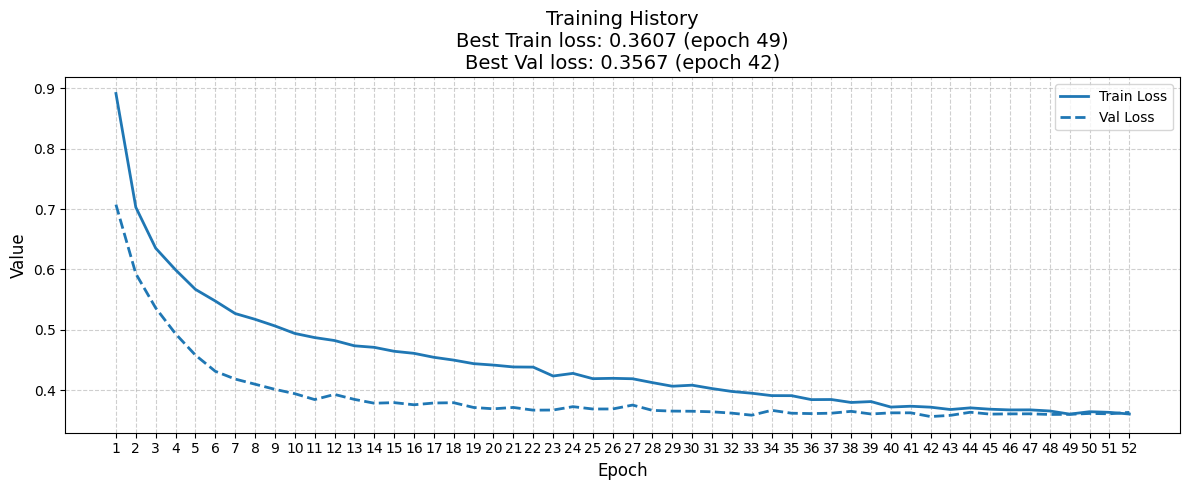

In [95]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=6,
        min_lr=1e-9,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]

set_random_seed() # mi sa che non va
d_hist = d_model.fit(
    x=d_train,
    validation_data=d_val,
    epochs=100,
    callbacks=callbacks
)
plot_history(d_hist)

In [96]:
try:
    l = min(d_hist.history['val_loss'])
    model_arc = '-'.join(['k'.join([str(f),str(k)]) for f,k in zip(conv_filters, kernel_sizes)])
    name = f"./multi-agent-models/conv/daily/daily_{model_arc}_{'-'.join(str(h) for h in head_hidden_units)}_loss{str(round(l,4)).replace('.','-')}.h5"
    d_model.save_weights(name)
    print(f'Weights saved: {name}')
except NameError: pass

Weights saved: ./multi-agent-models/conv/daily/daily_256k3-128k3-64k3_64-32_loss0-3567.h5


In [97]:
d_model.summary()


Model: multi_agent_model_8
Layer (type)                       Output Shape                  Param #        
masking_8                           (None, 24, 22)                 0              
conv1d_0                            (None, 24, 256)                17152          
conv1d_1                            (None, 24, 128)                98432          
conv1d_2                            (None, 24, 64)                 24640          
global_average_pooling1d_8          (None, 64)                     0              

PM10_head.dense_48                  (None, 64)                     4160           
PM10_head.dropout_32                (None, 64)                     0              
PM10_head.dense_49                  (None, 32)                     2080           
PM10_head.dropout_33                (None, 32)                     0              
PM10_head.dense_50                  (None, 1)                      33             

PM2.5_head.dense_51                 (None, 64)             

In [98]:
def map_inputs(x, a, *rest):
    return (x, a),

d_results = d_model.predict(d_test.map(map_inputs)) # only pass sequence and agent id

56/56 [==============================] - 1s 9ms/step


In [99]:
d_agent_values = {
    'true': {},
    'predictions': {}
}
i = 0

for _, agent_ids, targets, station_ids, dates in d_test:
    agent_ids = agent_ids.numpy()
    targets = targets.numpy()
    station_ids = station_ids.numpy()

    for a, t, s, d in zip(agent_ids, targets, station_ids, dates):
        s_key = stations[s]
        a_key = a.decode('utf-8')
        if s_key not in d_agent_values['true']:
            d_agent_values['true'][s_key] = {}
            d_agent_values['predictions'][s_key] = {}
        if a_key not in d_agent_values['true'][s_key]:
            d_agent_values['true'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            d_agent_values['predictions'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            d_agent_values['true'][s_key][a_key].index.name = 'Date'
            d_agent_values['predictions'][s_key][a_key].index.name = 'Date'
        
        date_index = d.numpy().decode('utf-8')
        d_agent_values['true'][s_key][a_key].loc[pd.to_datetime(date_index)] = t
        d_agent_values['predictions'][s_key][a_key].loc[pd.to_datetime(date_index)] = d_results[i]
        i+=1

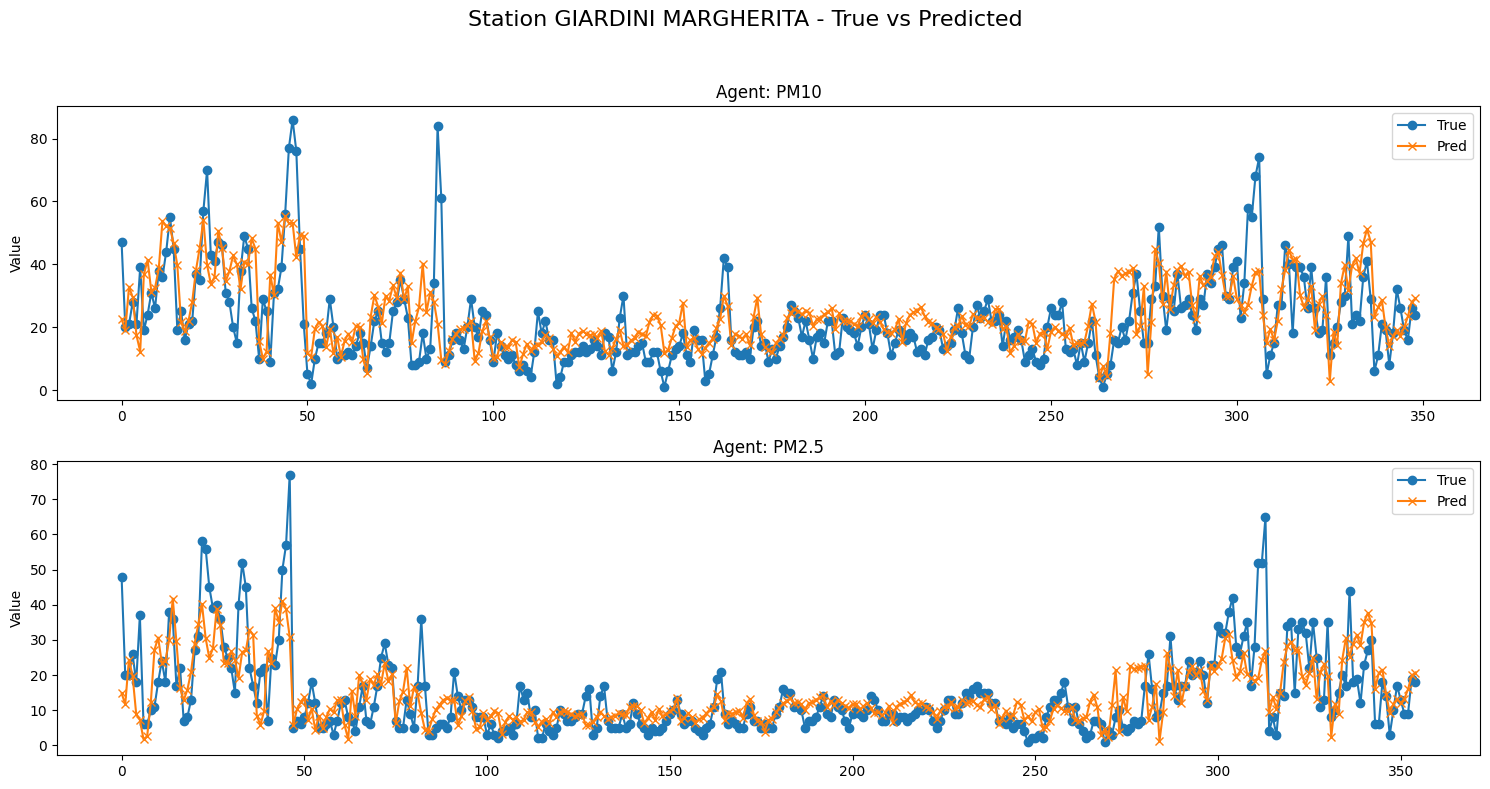

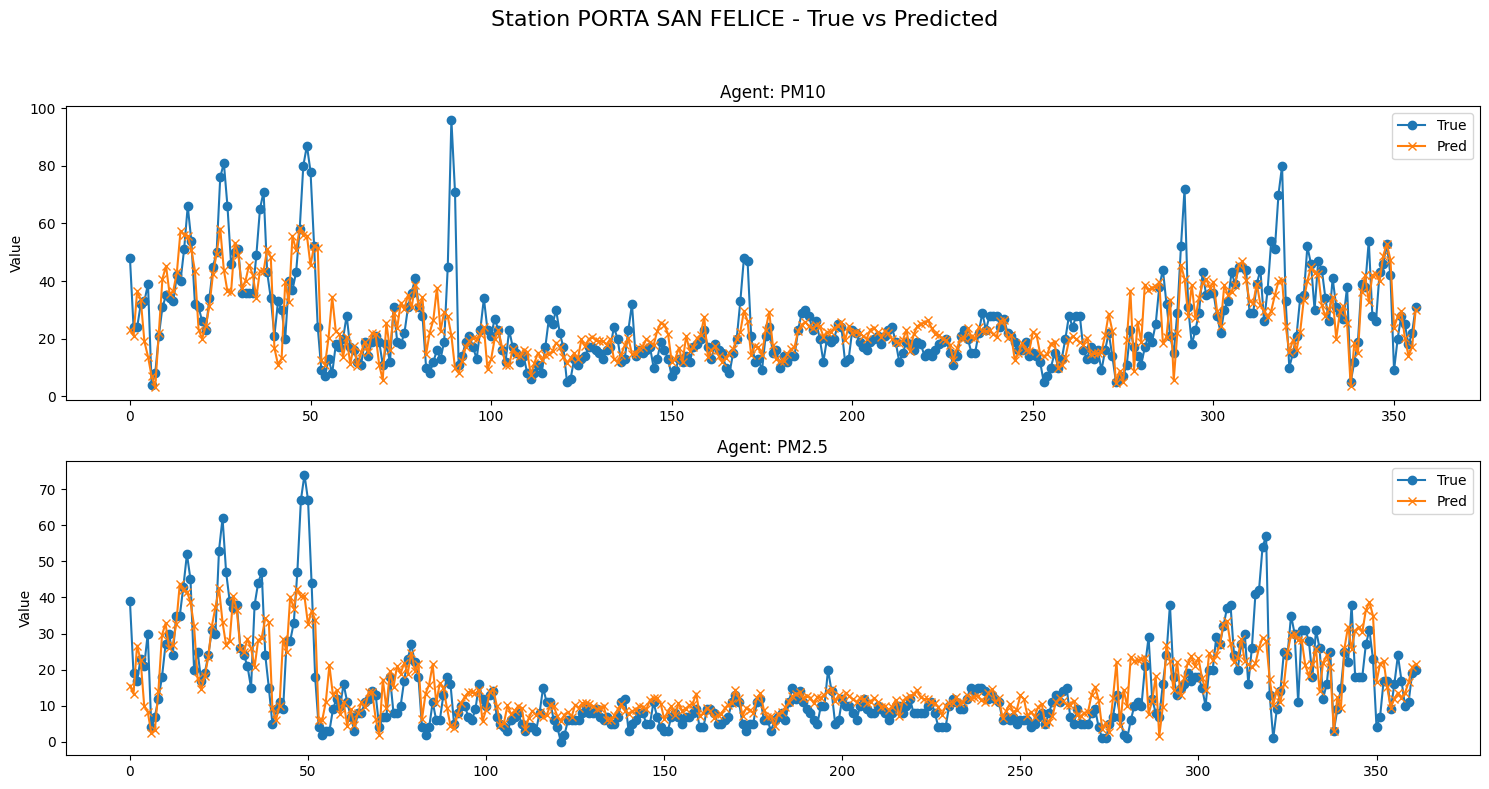

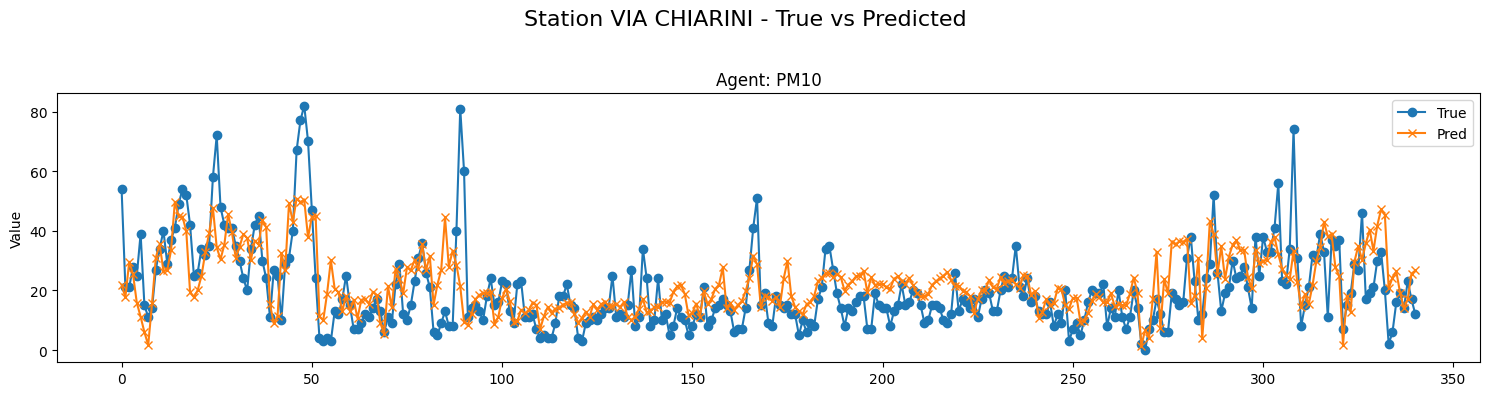

In [100]:
plot_predictions(d_agent_values, agent_distributions, max_elements_per_plot=999)

### **Hourly**

In [102]:
BATCH_SIZE = 32

h_train = h_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
h_val = h_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
h_test = h_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [105]:
conv_filters=(256, 128, 128, 64)
kernel_sizes=(3, 3, 3, 3)
head_hidden_units = (64, 64, 32)

h_model = MultiAgentModel(
    input_shape=hourly_input_shape,
    task_ids=['PM10','PM2.5'],
    conv_filters=conv_filters,
    kernel_sizes=kernel_sizes,
    head_hidden_units=head_hidden_units,
)
h_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mse",       # mean squared error for regression
    metrics=["mae"],  # mean absolute error
    weighted_metrics=[]
)

In [ ]:
try:
    h_model.evaluate(d_val.take(1)) # init the model
    model_arc = '-'.join(['k'.join([str(f),str(k)]) for f,k in zip(conv_filters, kernel_sizes)])
    name = f"./multi-agent-models/conv/hourly/hourly_{model_arc}_{'-'.join(str(h) for h in head_hidden_units)}_loss0-.h5"
    print(f'Trying to load {name}')
    h_model.load_weights(name)
    print('Successfully loaded weights')
except (ValueError, FileNotFoundError) as e: 
    print(f'Failed loading weights.\n{e}')

1/1 [==============================] - 5s 5s/step - loss: 1.4358 - mae: 1.0190
Trying to load ./multi-agent-models/hourly/hourly_64-64-64_64-32_loss0-2251.h5
Successfully loaded weights


Epoch 1/100
8388/8388 [==============================] - 173s 13ms/step - loss: 0.8077 - mae: 0.7134 - val_loss: 0.7433 - val_mae: 0.6917 - lr: 1.0000e-04
Epoch 2/100
8388/8388 [==============================] - 172s 13ms/step - loss: 0.7692 - mae: 0.6978 - val_loss: 0.7254 - val_mae: 0.6873 - lr: 1.0000e-04
Epoch 3/100
8388/8388 [==============================] - 172s 13ms/step - loss: 0.7495 - mae: 0.6903 - val_loss: 0.7140 - val_mae: 0.6806 - lr: 1.0000e-04
Epoch 4/100
8388/8388 [==============================] - 169s 13ms/step - loss: 0.7350 - mae: 0.6846 - val_loss: 0.7107 - val_mae: 0.6757 - lr: 1.0000e-04
Epoch 5/100
8388/8388 [==============================] - 175s 13ms/step - loss: 0.7246 - mae: 0.6801 - val_loss: 0.6959 - val_mae: 0.6812 - lr: 1.0000e-04
Epoch 6/100
8388/8388 [==============================] - 168s 13ms/step - loss: 0.7141 - mae: 0.6762 - val_loss: 0.6861 - val_mae: 0.6699 - lr: 1.0000e-04
Epoch 7/100
8388/8388 [==============================] - 169s 13ms/ste

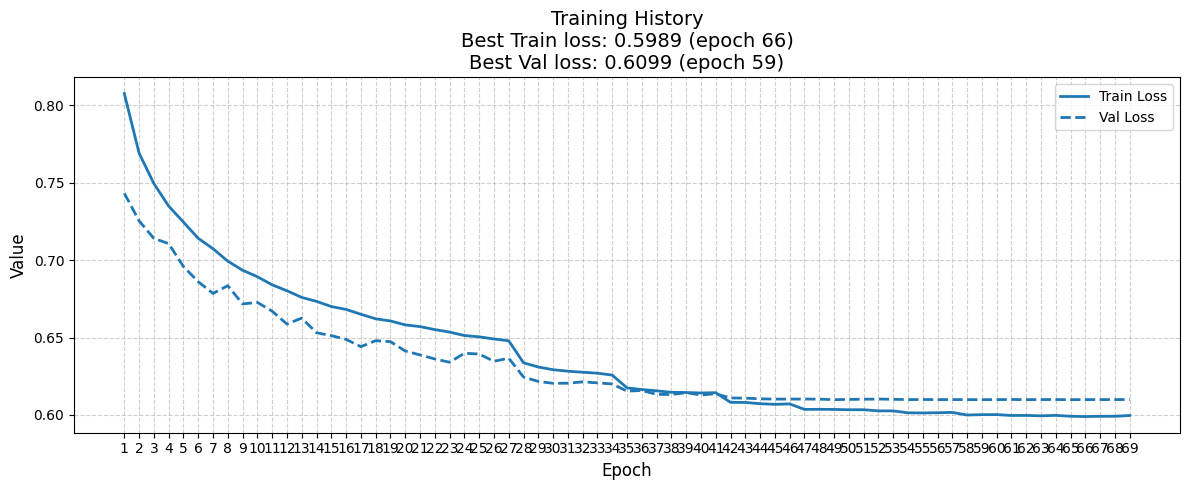

In [106]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=4,
        min_lr=1e-9,
        verbose=1,
        min_delta=0.001
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]

set_random_seed() # mi sa che non va
h_hist = h_model.fit(
    x=h_train,
    validation_data=h_val,
    epochs=100,
    callbacks=callbacks
)
plot_history(h_hist)

In [107]:
try:
    l = min(h_hist.history['val_loss'])
    model_arc = '-'.join(['k'.join([str(f),str(k)]) for f,k in zip(conv_filters, kernel_sizes)])
    name = f"./multi-agent-models/conv/hourly/hourly_{model_arc}_{'-'.join(str(h) for h in head_hidden_units)}_loss{str(round(l,4)).replace('.','-')}.h5"
    h_model.save_weights(name)
    print(f'Weights saved: {name}')
except NameError: pass

Weights saved: ./multi-agent-models/conv/hourly/hourly_256k3-128k3-128k3-64k3_64-64-32_loss0-6099.h5


In [108]:
h_model.summary()


Model: multi_agent_model_10
Layer (type)                       Output Shape                  Param #        
masking_10                          (None, 8, 24)                  0              
conv1d_0                            (None, 8, 256)                 18688          
conv1d_1                            (None, 8, 128)                 98432          
conv1d_2                            (None, 8, 128)                 49280          
conv1d_3                            (None, 8, 64)                  24640          
global_average_pooling1d_10         (None, 64)                     0              

PM10_head.dense_62                  (None, 64)                     4160           
PM10_head.dropout_42                (None, 64)                     0              
PM10_head.dense_63                  (None, 64)                     4160           
PM10_head.dropout_43                (None, 64)                     0              
PM10_head.dense_64                  (None, 32)             

In [109]:
def map_inputs(x, a, *rest):
    return (x, a),

h_results = h_model.predict(h_test.map(map_inputs)) # only pass sequence and agent id

1886/1886 [==============================] - 19s 10ms/step


In [110]:
h_agent_values = {
    'true': {},
    'predictions': {}
}
i = 0

for _, agent_ids, targets, station_ids, dates in h_test:
    agent_ids = agent_ids.numpy()
    targets = targets.numpy()
    station_ids = station_ids.numpy()

    for a, t, s, d in zip(agent_ids, targets, station_ids, dates):
        s_key = stations[s]
        a_key = a.decode('utf-8')
        if s_key not in h_agent_values['true']:
            h_agent_values['true'][s_key] = {}
            h_agent_values['predictions'][s_key] = {}
        if a_key not in h_agent_values['true'][s_key]:
            h_agent_values['true'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            h_agent_values['predictions'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            h_agent_values['true'][s_key][a_key].index.name = 'Date'
            h_agent_values['predictions'][s_key][a_key].index.name = 'Date'
        
        date_index = d.numpy().decode('utf-8')
        h_agent_values['true'][s_key][a_key].loc[pd.to_datetime(date_index)] = t
        h_agent_values['predictions'][s_key][a_key].loc[pd.to_datetime(date_index)] = h_results[i]
        i+=1

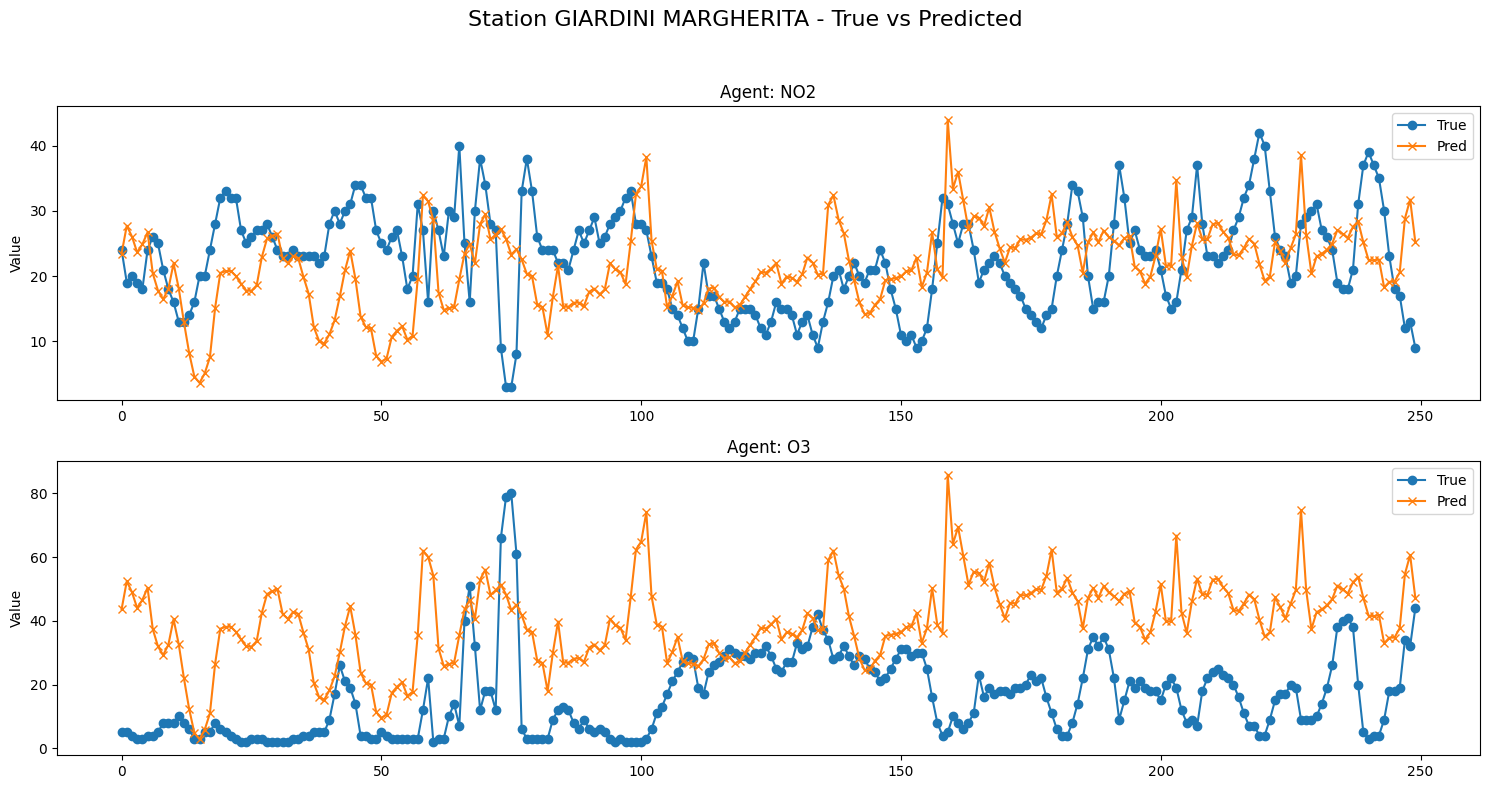

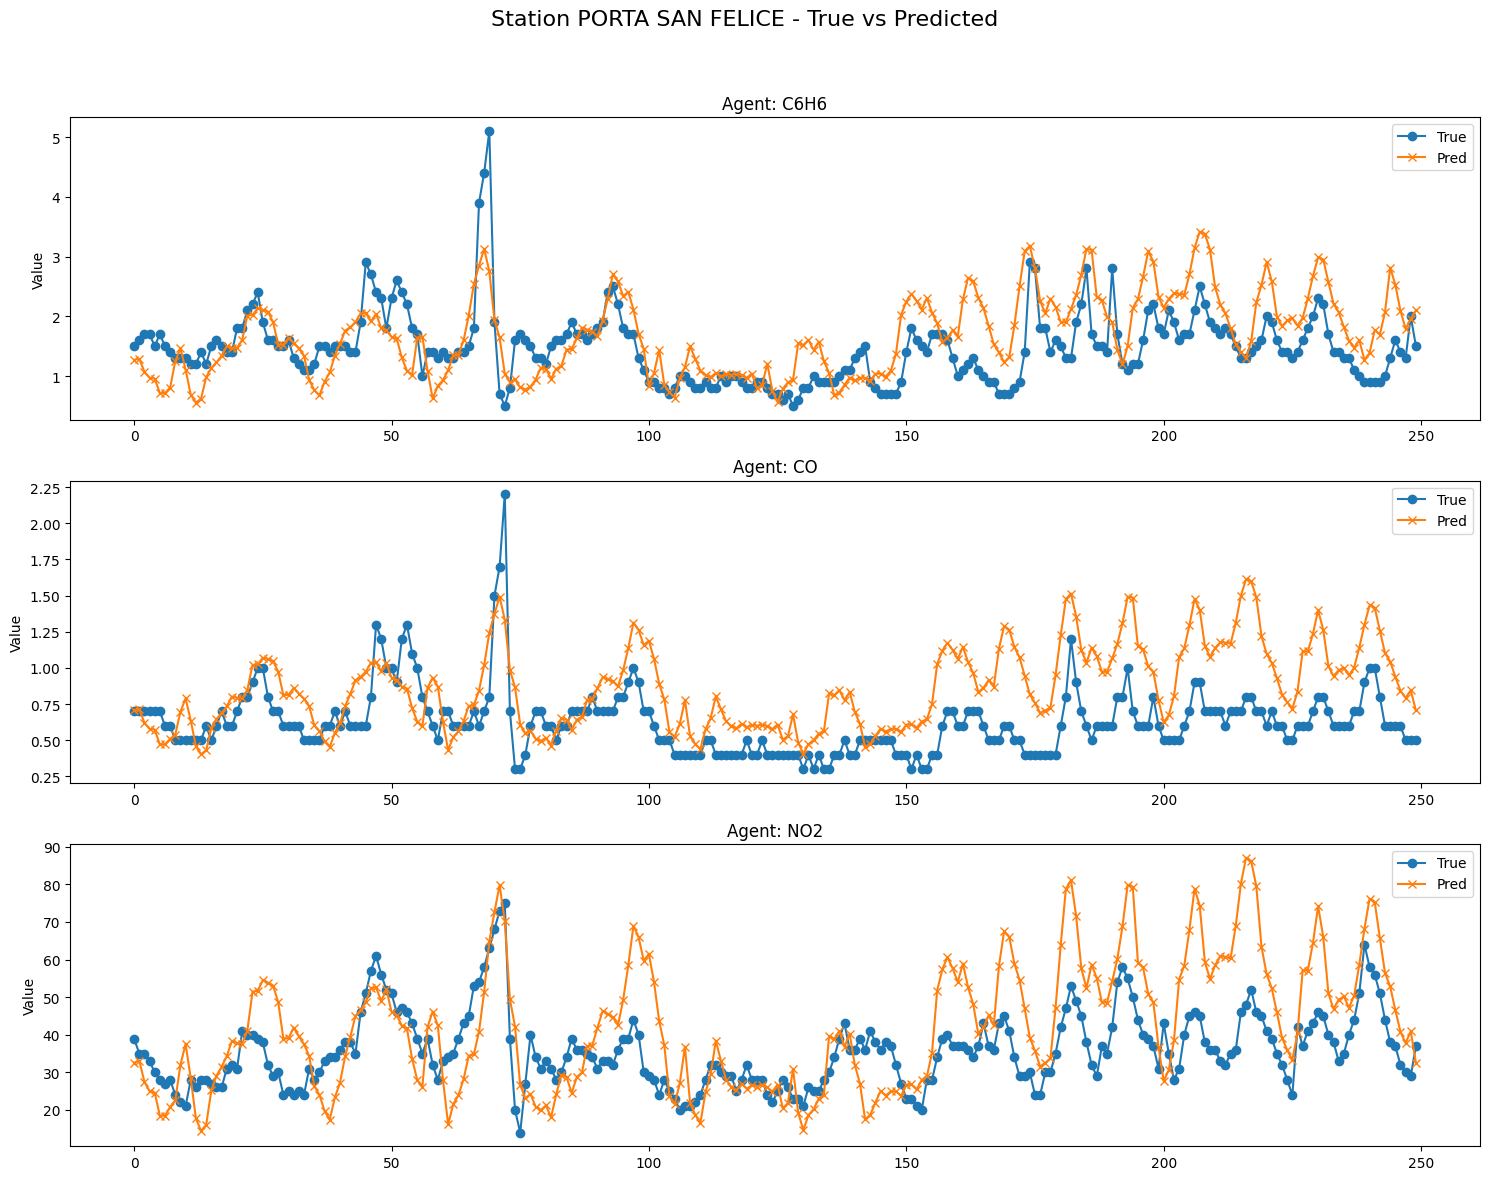

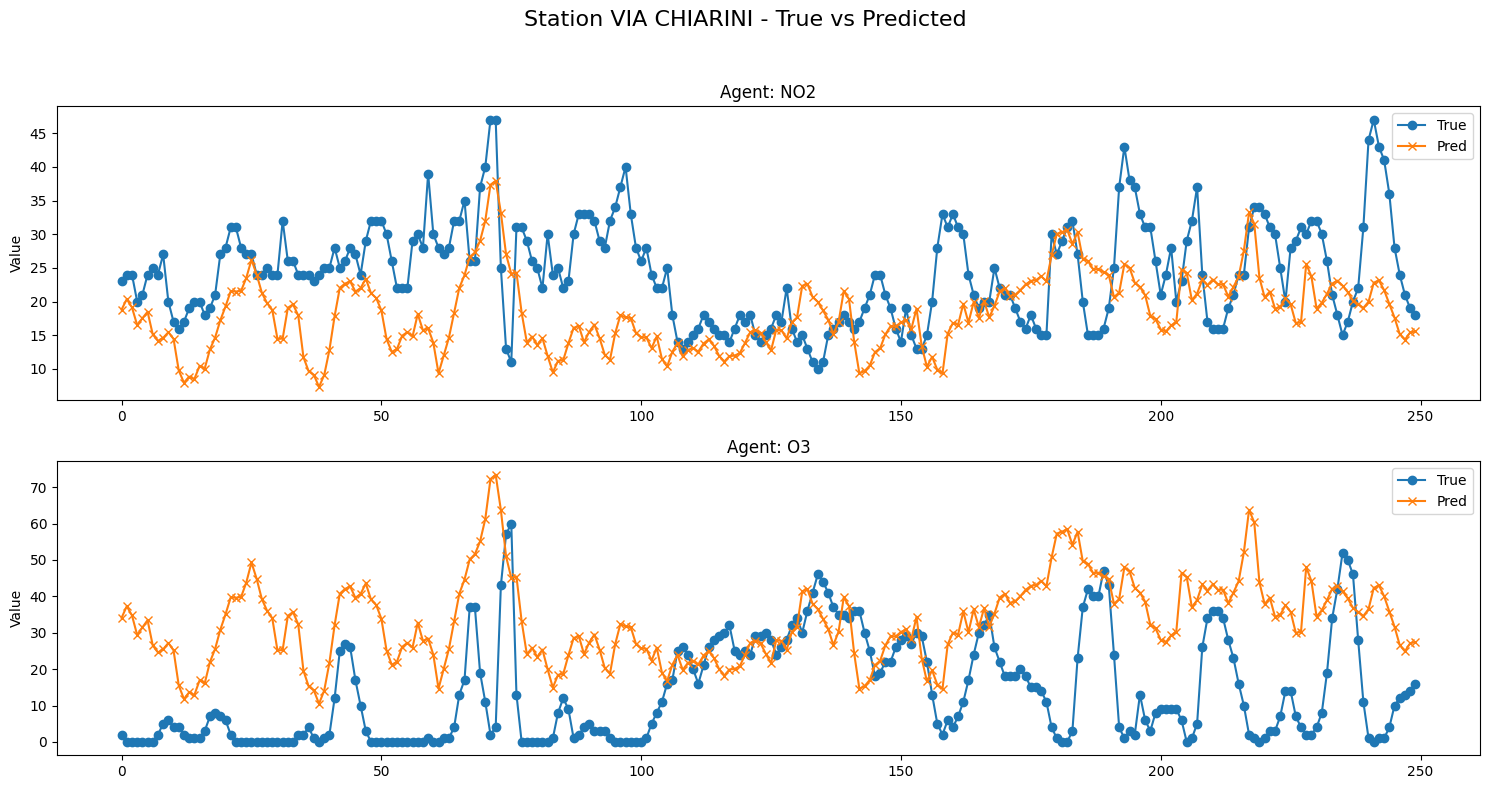

In [111]:
plot_predictions(
    h_agent_values, 
    agent_distributions, 
    max_elements_per_plot=250
)

## **Air Quality Index**

### **AQI calculation**

In [112]:
agent_values = {
    'predictions': {},
    'true': {}
}
# we should merge here the results of the two models, such to have a singular dict for every station
for station in stations:
    agent_values['predictions'][station] = {}
    agent_values['true'][station] = {}
    for agent in h_agent_values['predictions'][station]:
        agent_values['predictions'][station][agent] = (h_agent_values['predictions'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0)
        agent_values['true'][station][agent] = (h_agent_values['true'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0) # should not be needed
    for agent in d_agent_values['predictions'][station]:
        agent_values['predictions'][station][agent] = (d_agent_values['predictions'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0)
        agent_values['true'][station][agent] = (d_agent_values['true'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0) # should not be needed

for station in stations:
    print(
          f"{station}:\n"
          f"  preds: {agent_values['predictions'][station].keys()}\n"
          f"  true: {agent_values['true'][station].keys()}"
    )
    for a in agent_values['predictions'][station]:
        if len(agent_values['predictions'][station][a]) != len(agent_values['true'][station][a]):
            print(f'Inconsistent lenghts for {a} in {station}')

GIARDINI MARGHERITA:
  preds: dict_keys(['NO2', 'O3', 'PM10', 'PM2.5'])
  true: dict_keys(['NO2', 'O3', 'PM10', 'PM2.5'])
PORTA SAN FELICE:
  preds: dict_keys(['C6H6', 'CO', 'NO2', 'PM10', 'PM2.5'])
  true: dict_keys(['C6H6', 'CO', 'NO2', 'PM10', 'PM2.5'])
VIA CHIARINI:
  preds: dict_keys(['NO2', 'O3', 'PM10'])
  true: dict_keys(['NO2', 'O3', 'PM10'])


In [113]:
predictions = agent_values['predictions']
true_values = agent_values['true']

pred_AQIs_daily = {s: {agent: get_AQI(predictions[s][agent], agent=agent, period='day', value_column='Agent_value',) for agent in predictions[s].keys()} for s in predictions}
pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')
pred_AQIs_hourly = {s: {agent: get_AQI(predictions[s][agent],agent=agent,period='hour', value_column='Agent_value',include_hourly_pm=False) for agent in predictions[s].keys()} for s in predictions}
pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')
true_AQIs_daily = {s: {agent: get_AQI(true_values[s][agent], agent=agent, period='day', value_column='Agent_value',) for agent in true_values[s].keys()} for s in true_values}
true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')
true_AQIs_hourly = {s: {agent: get_AQI(true_values[s][agent],agent=agent,period='hour', value_column='Agent_value',include_hourly_pm=False) for agent in true_values[s].keys()} for s in true_values}
true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')
AQI_diff_daily = {}
AQI_diff_hourly = {}
for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

### **Hourly**

Station GIARDINI MARGHERITA AQI:


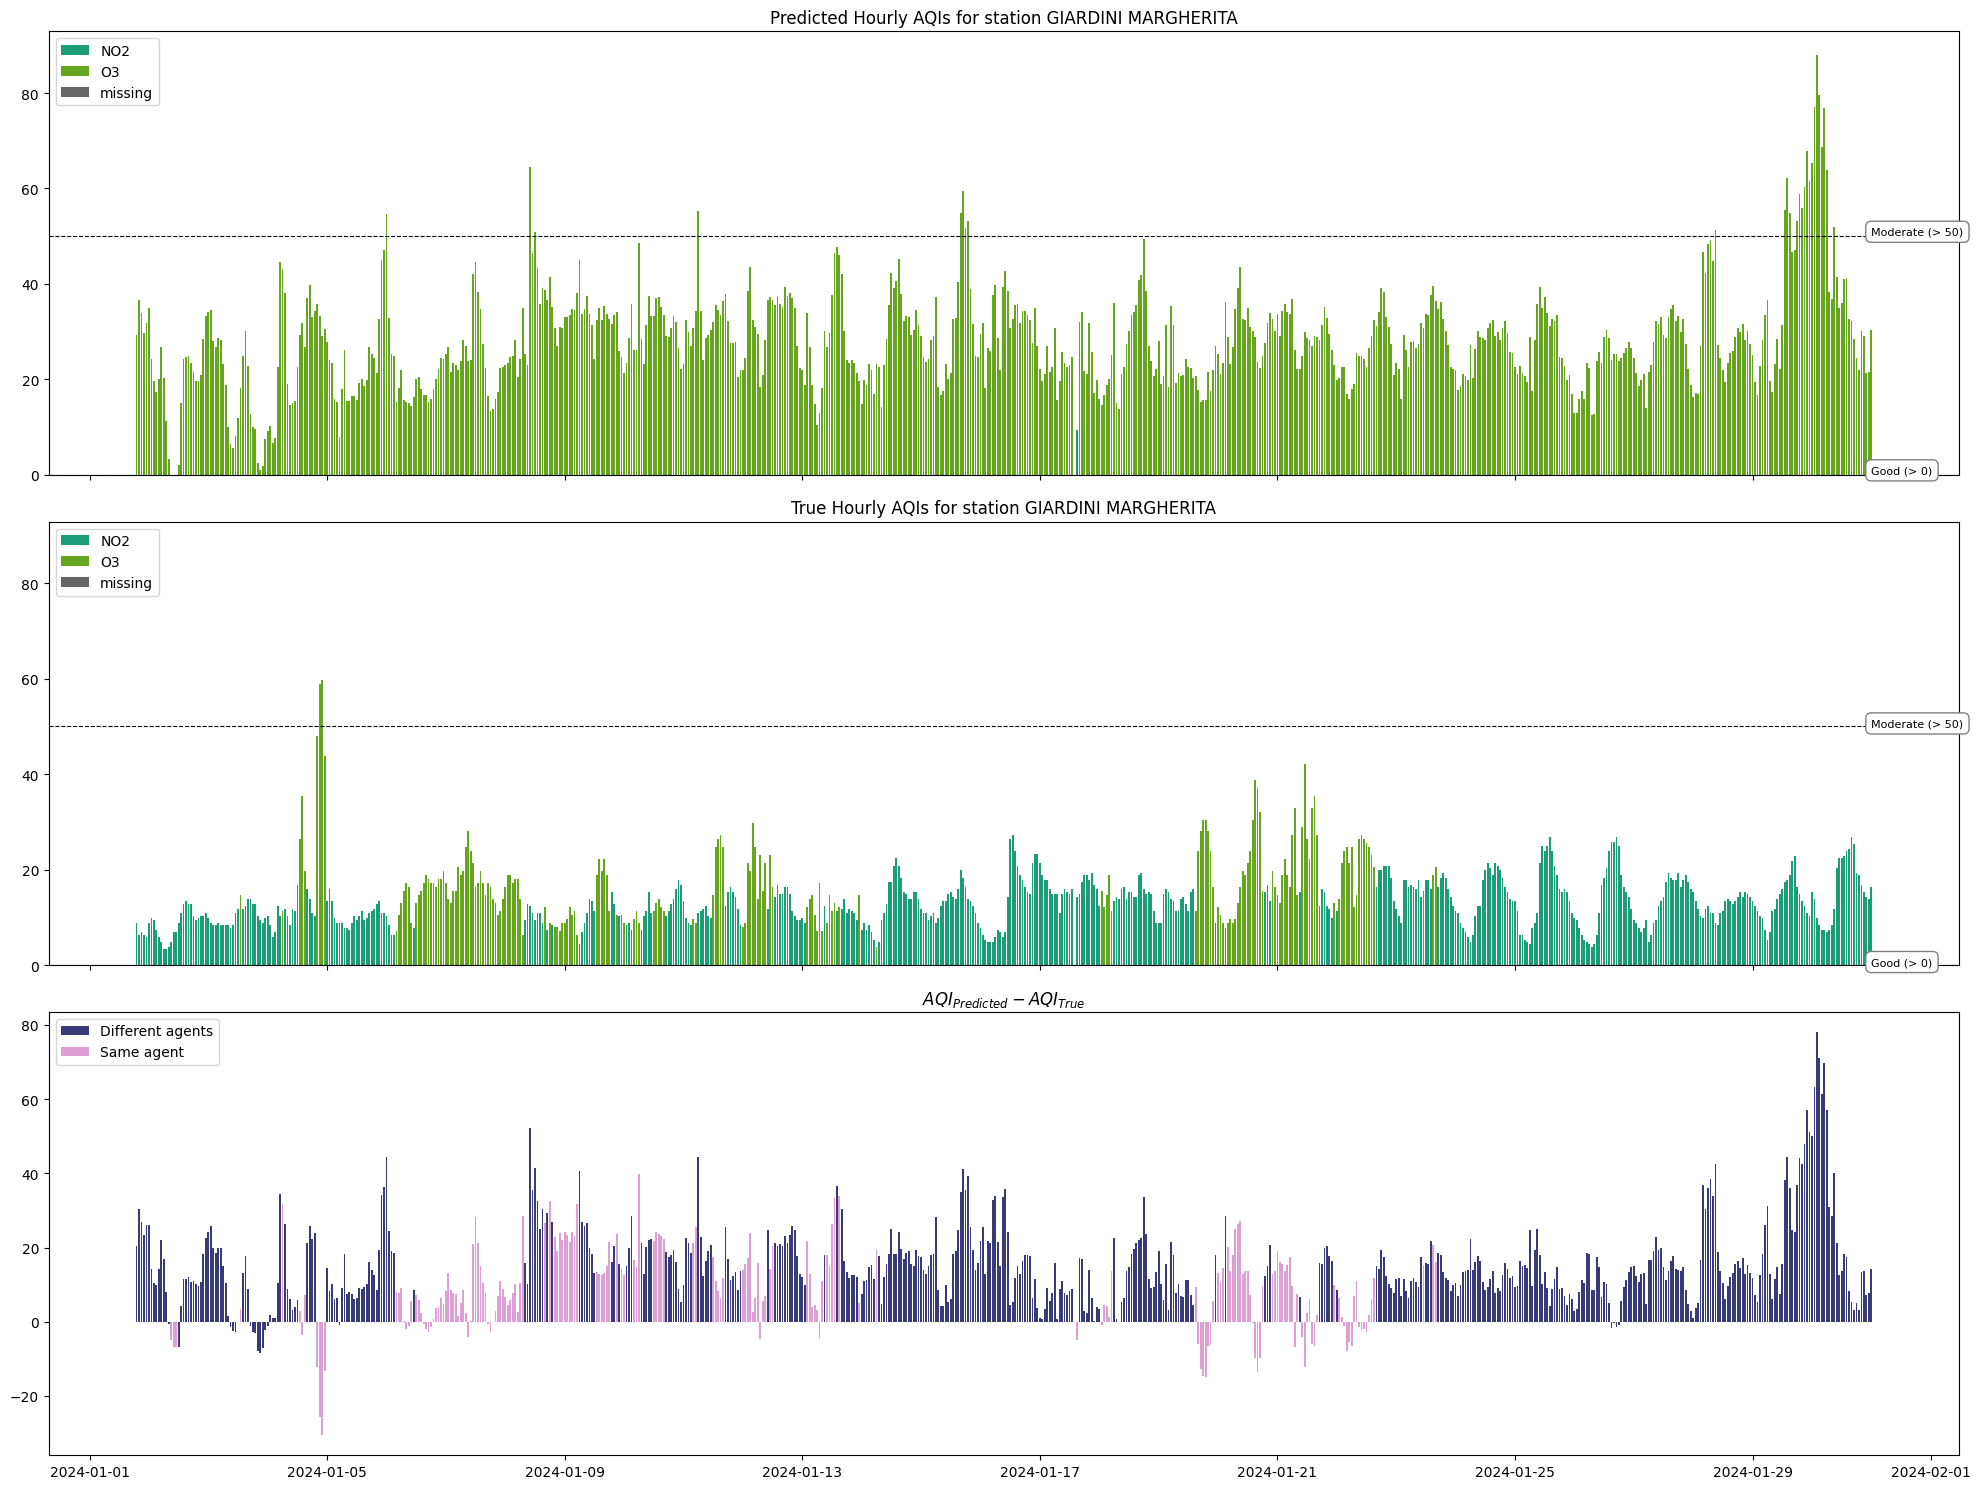

Station PORTA SAN FELICE AQI:


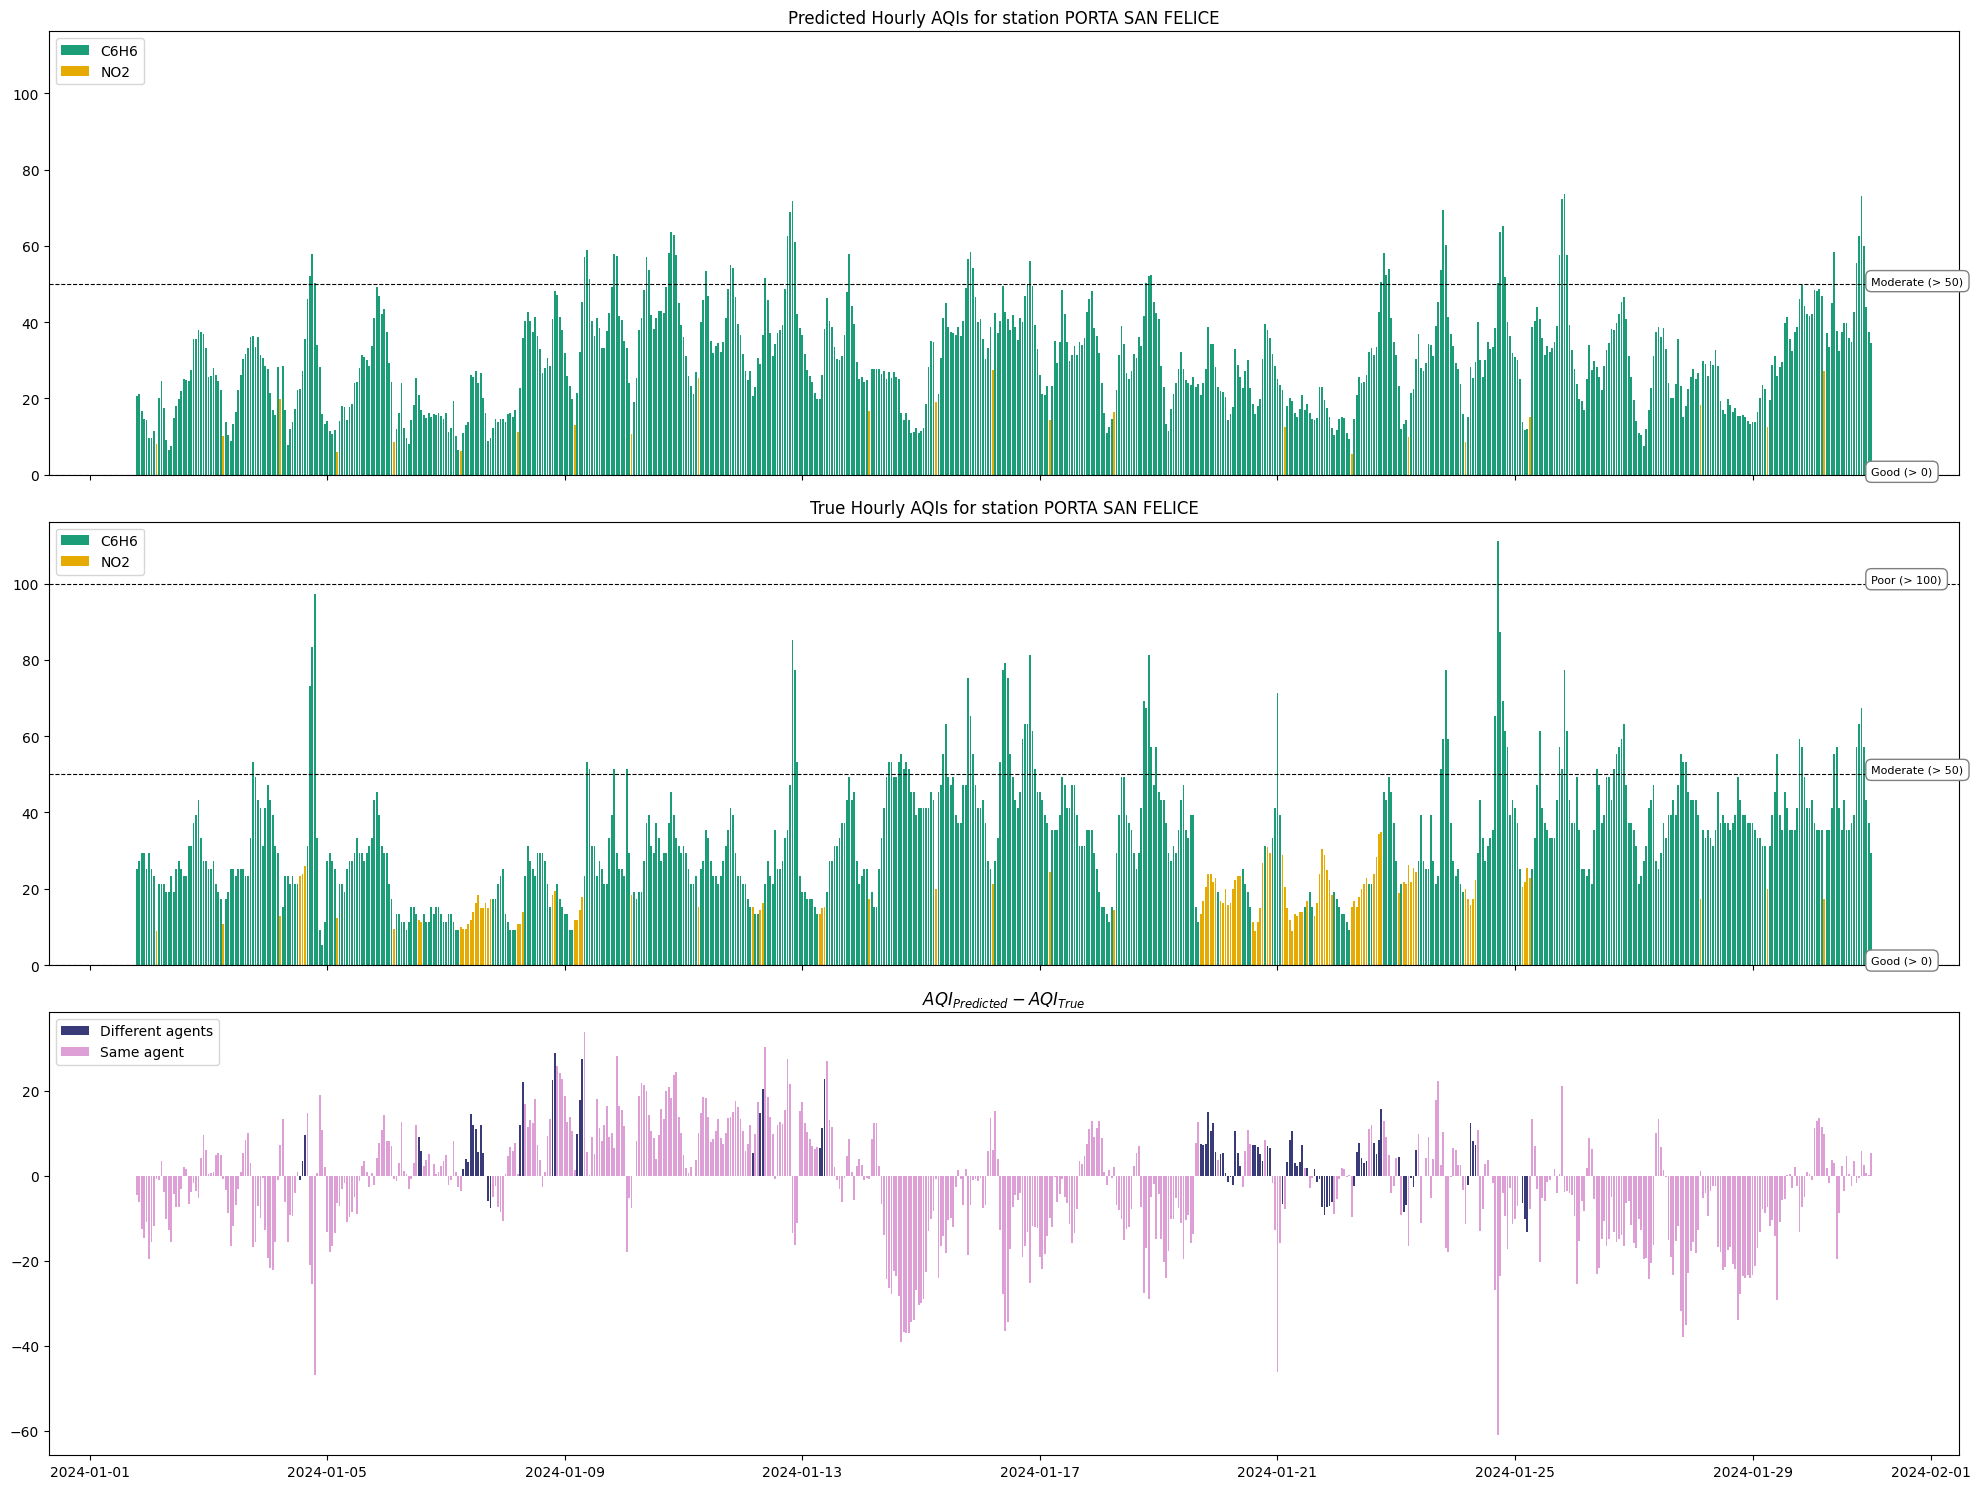

Station VIA CHIARINI AQI:


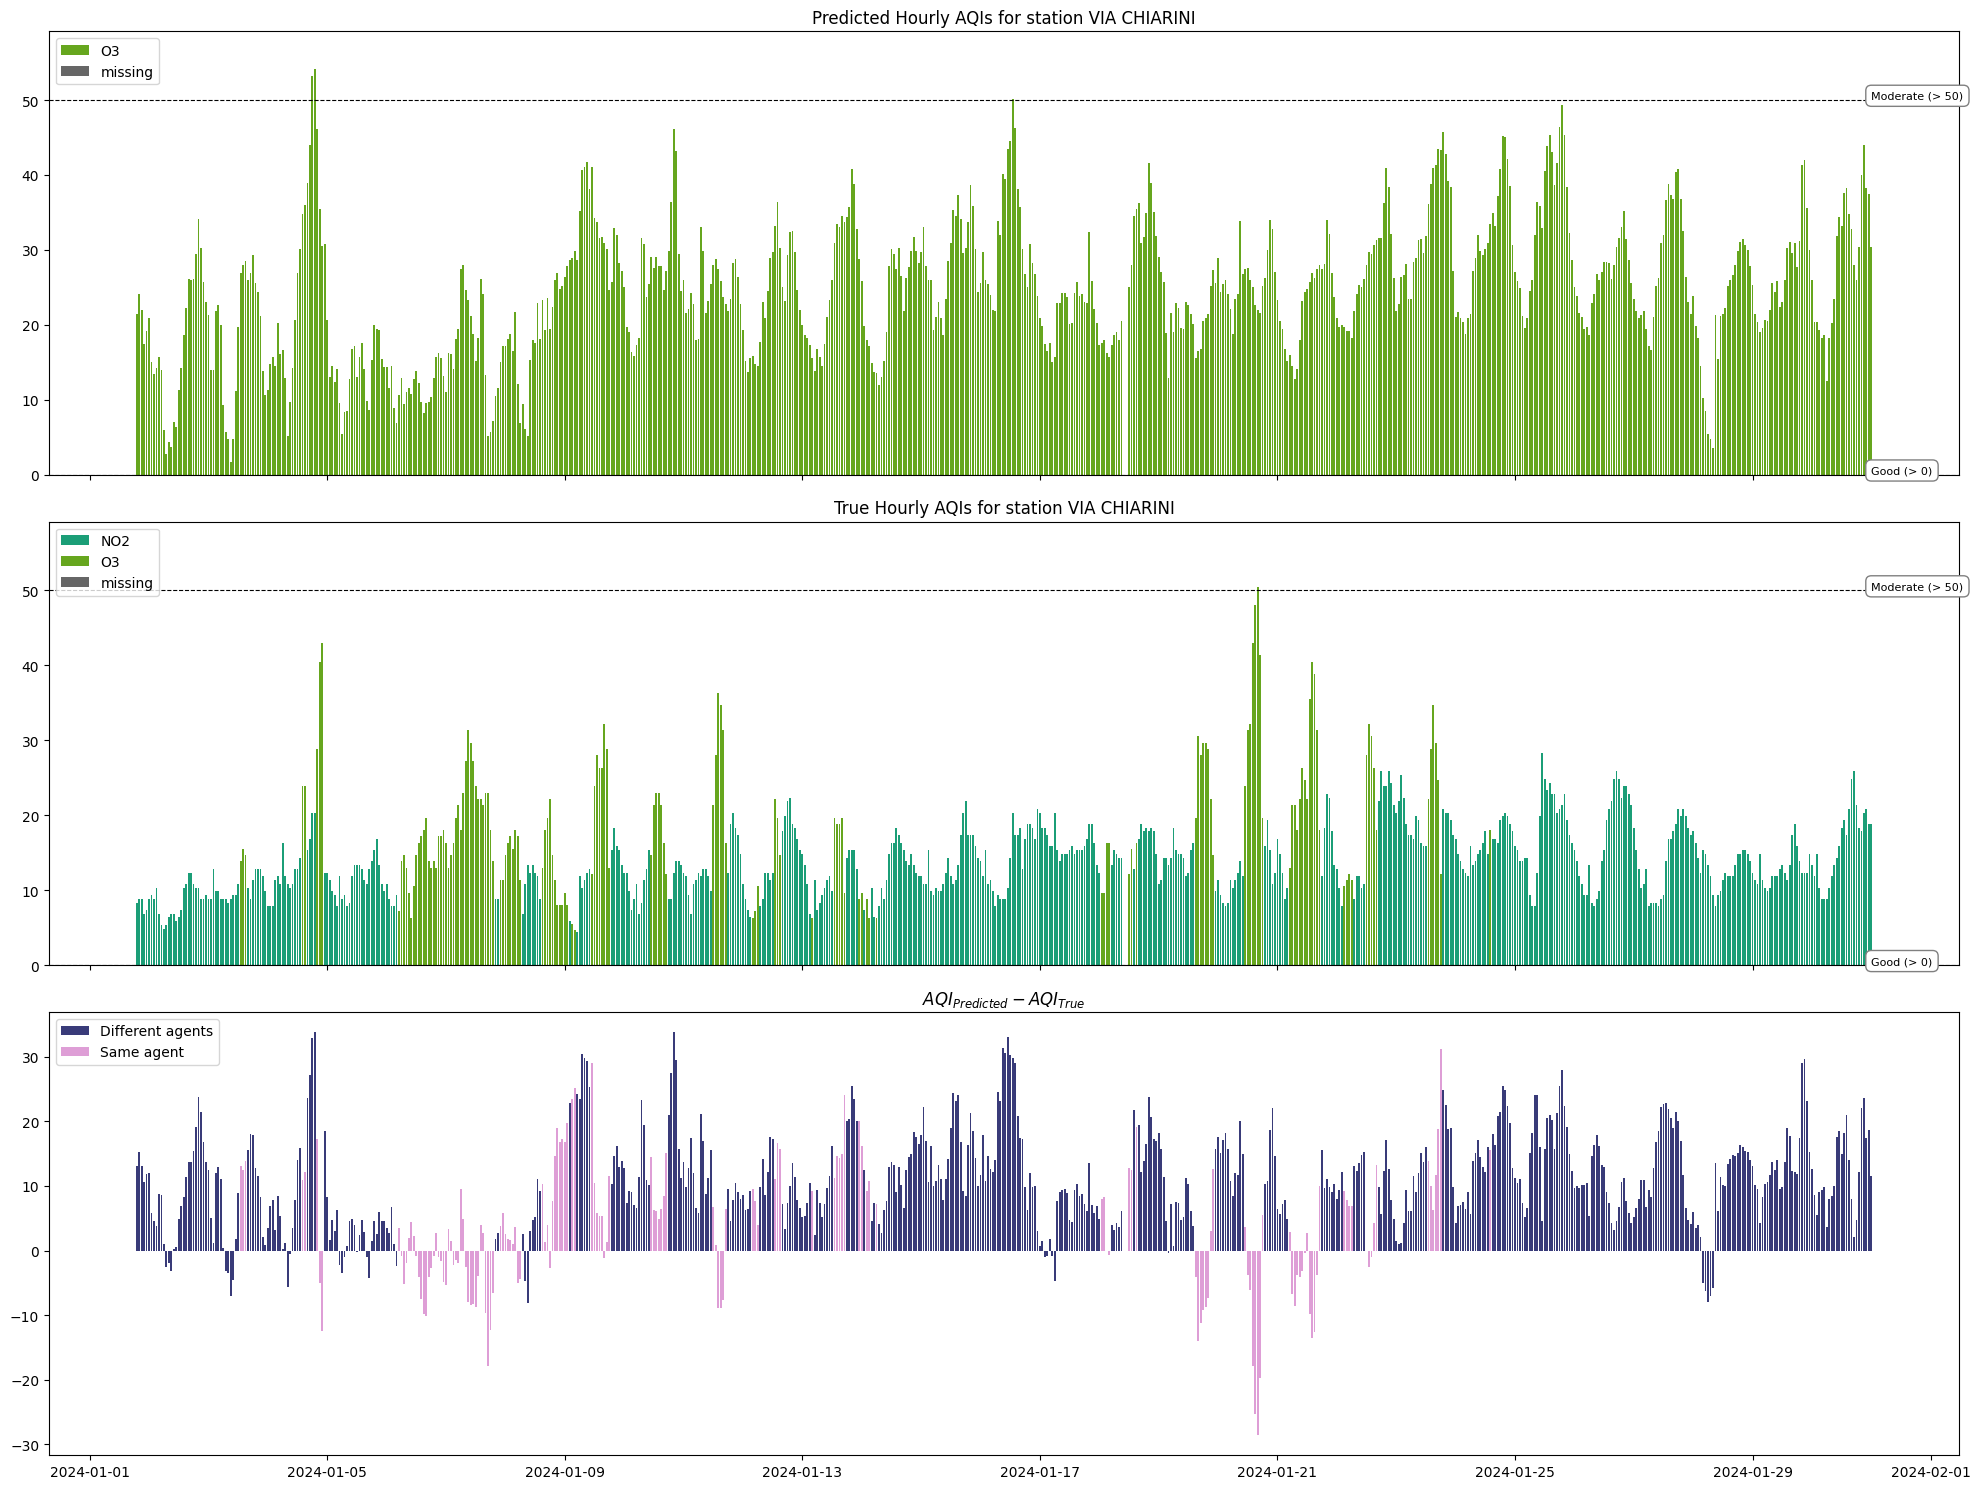

In [114]:
start=datetime(2024,1,1)
end=datetime(2024,1,31)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        categories=AQI_CATEGORIES,
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA Hourly


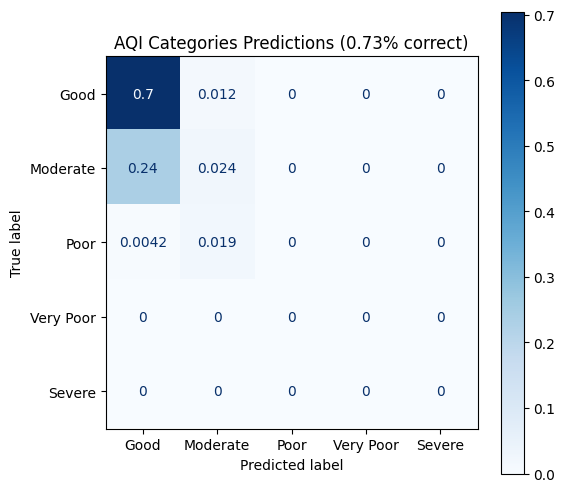

---------------------------------------------
> Absolute Mean AQI Difference: 19.07
> Positive Average AQI Difference: 12.95
> Negative Average AQI Difference: -23.94
> Percentage of Positive Differences: 44.20%
> Percentage of Negative Differences: 55.58%
> Percentage of Agent Values:
   - Same agent: 73.98
   - Different agents: 26.02
Station PORTA SAN FELICE Hourly


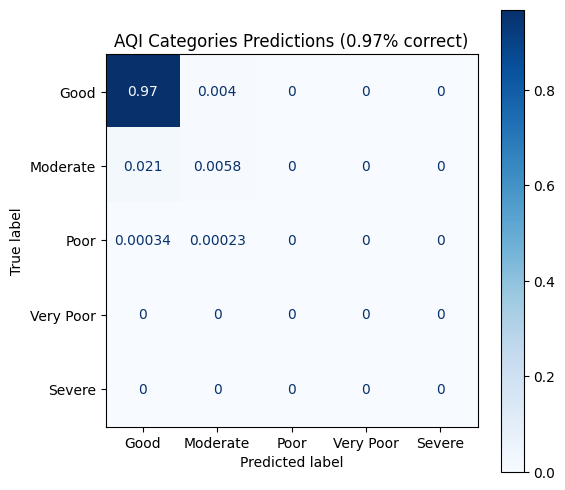

---------------------------------------------
> Absolute Mean AQI Difference: 7.20
> Positive Average AQI Difference: 6.37
> Negative Average AQI Difference: -8.23
> Percentage of Positive Differences: 54.67%
> Percentage of Negative Differences: 44.94%
> Percentage of Agent Values:
   - Same agent: 60.37
   - Different agents: 39.63
Station VIA CHIARINI Hourly


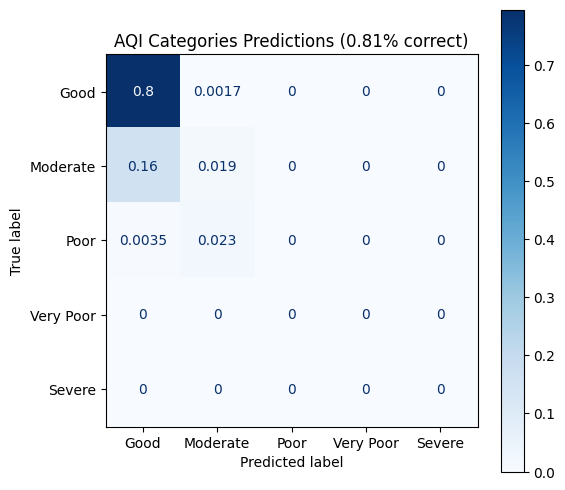

---------------------------------------------
> Absolute Mean AQI Difference: 15.03
> Positive Average AQI Difference: 9.74
> Negative Average AQI Difference: -20.80
> Percentage of Positive Differences: 52.08%
> Percentage of Negative Differences: 47.61%
> Percentage of Agent Values:
   - Same agent: 67.5
   - Different agents: 32.5


In [115]:
for station in pred_AQI_hourly:
    print('=============================================')
    print(f'Station {station} Hourly')
    print('=============================================')
    print_AQI_category_comparison(
        pred_AQI_hourly[station], 
        true_AQI_hourly[station], 
        categories=AQI_CATEGORIES,
        # categories=bla,
        # figsize=(20,20)
        )
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_hourly[station])
    print('=============================================')

### **Daily**

Station GIARDINI MARGHERITA AQI:


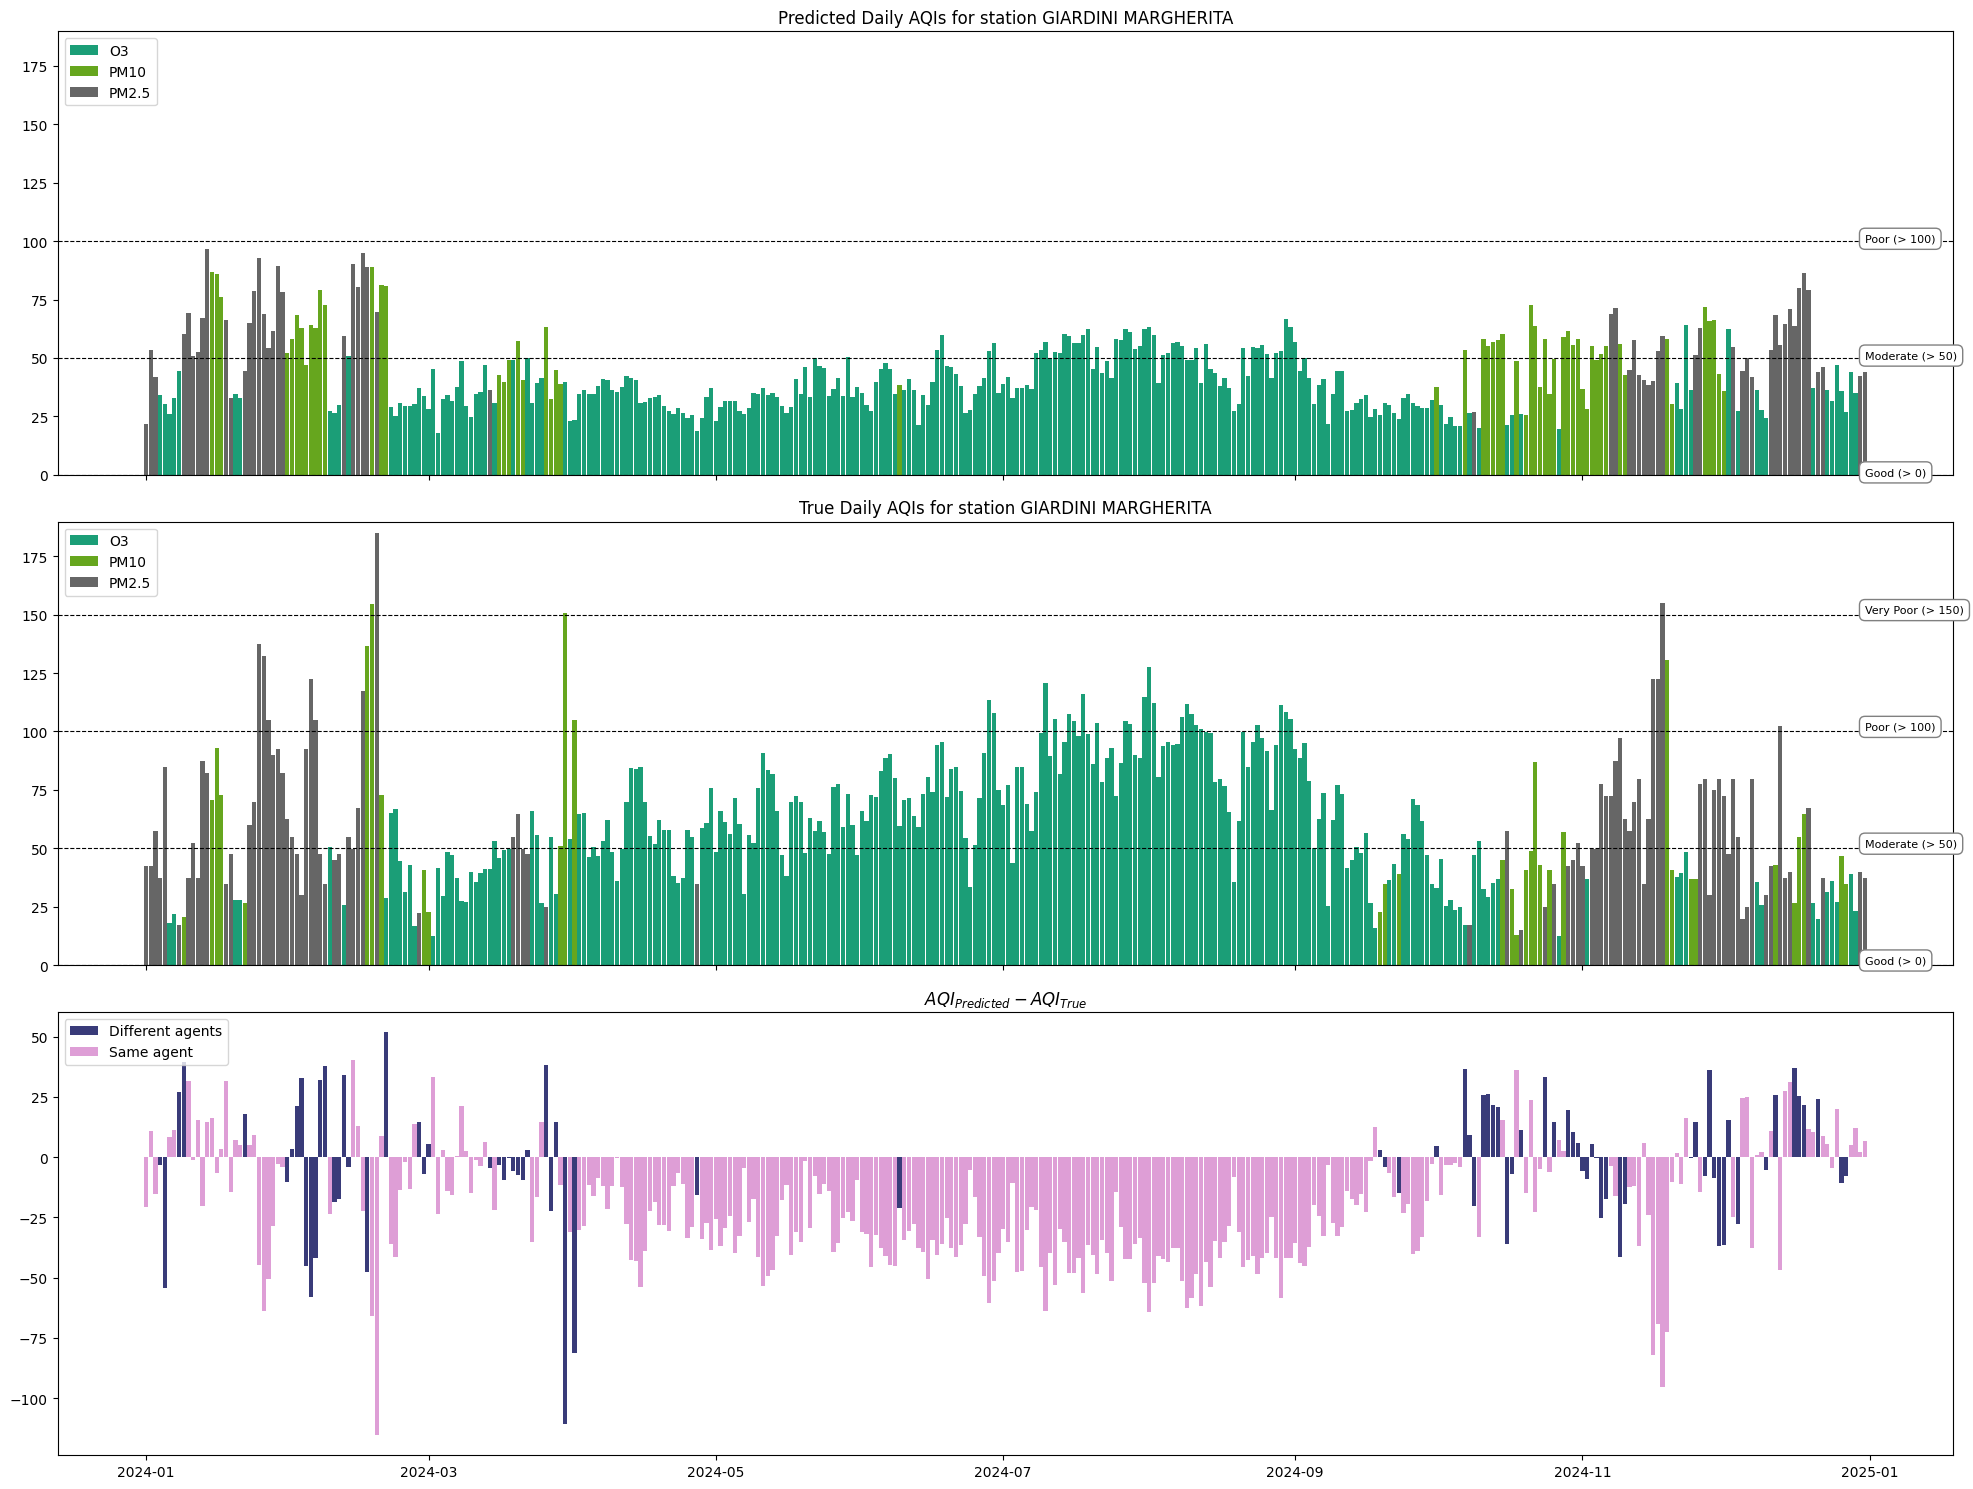

Station PORTA SAN FELICE AQI:


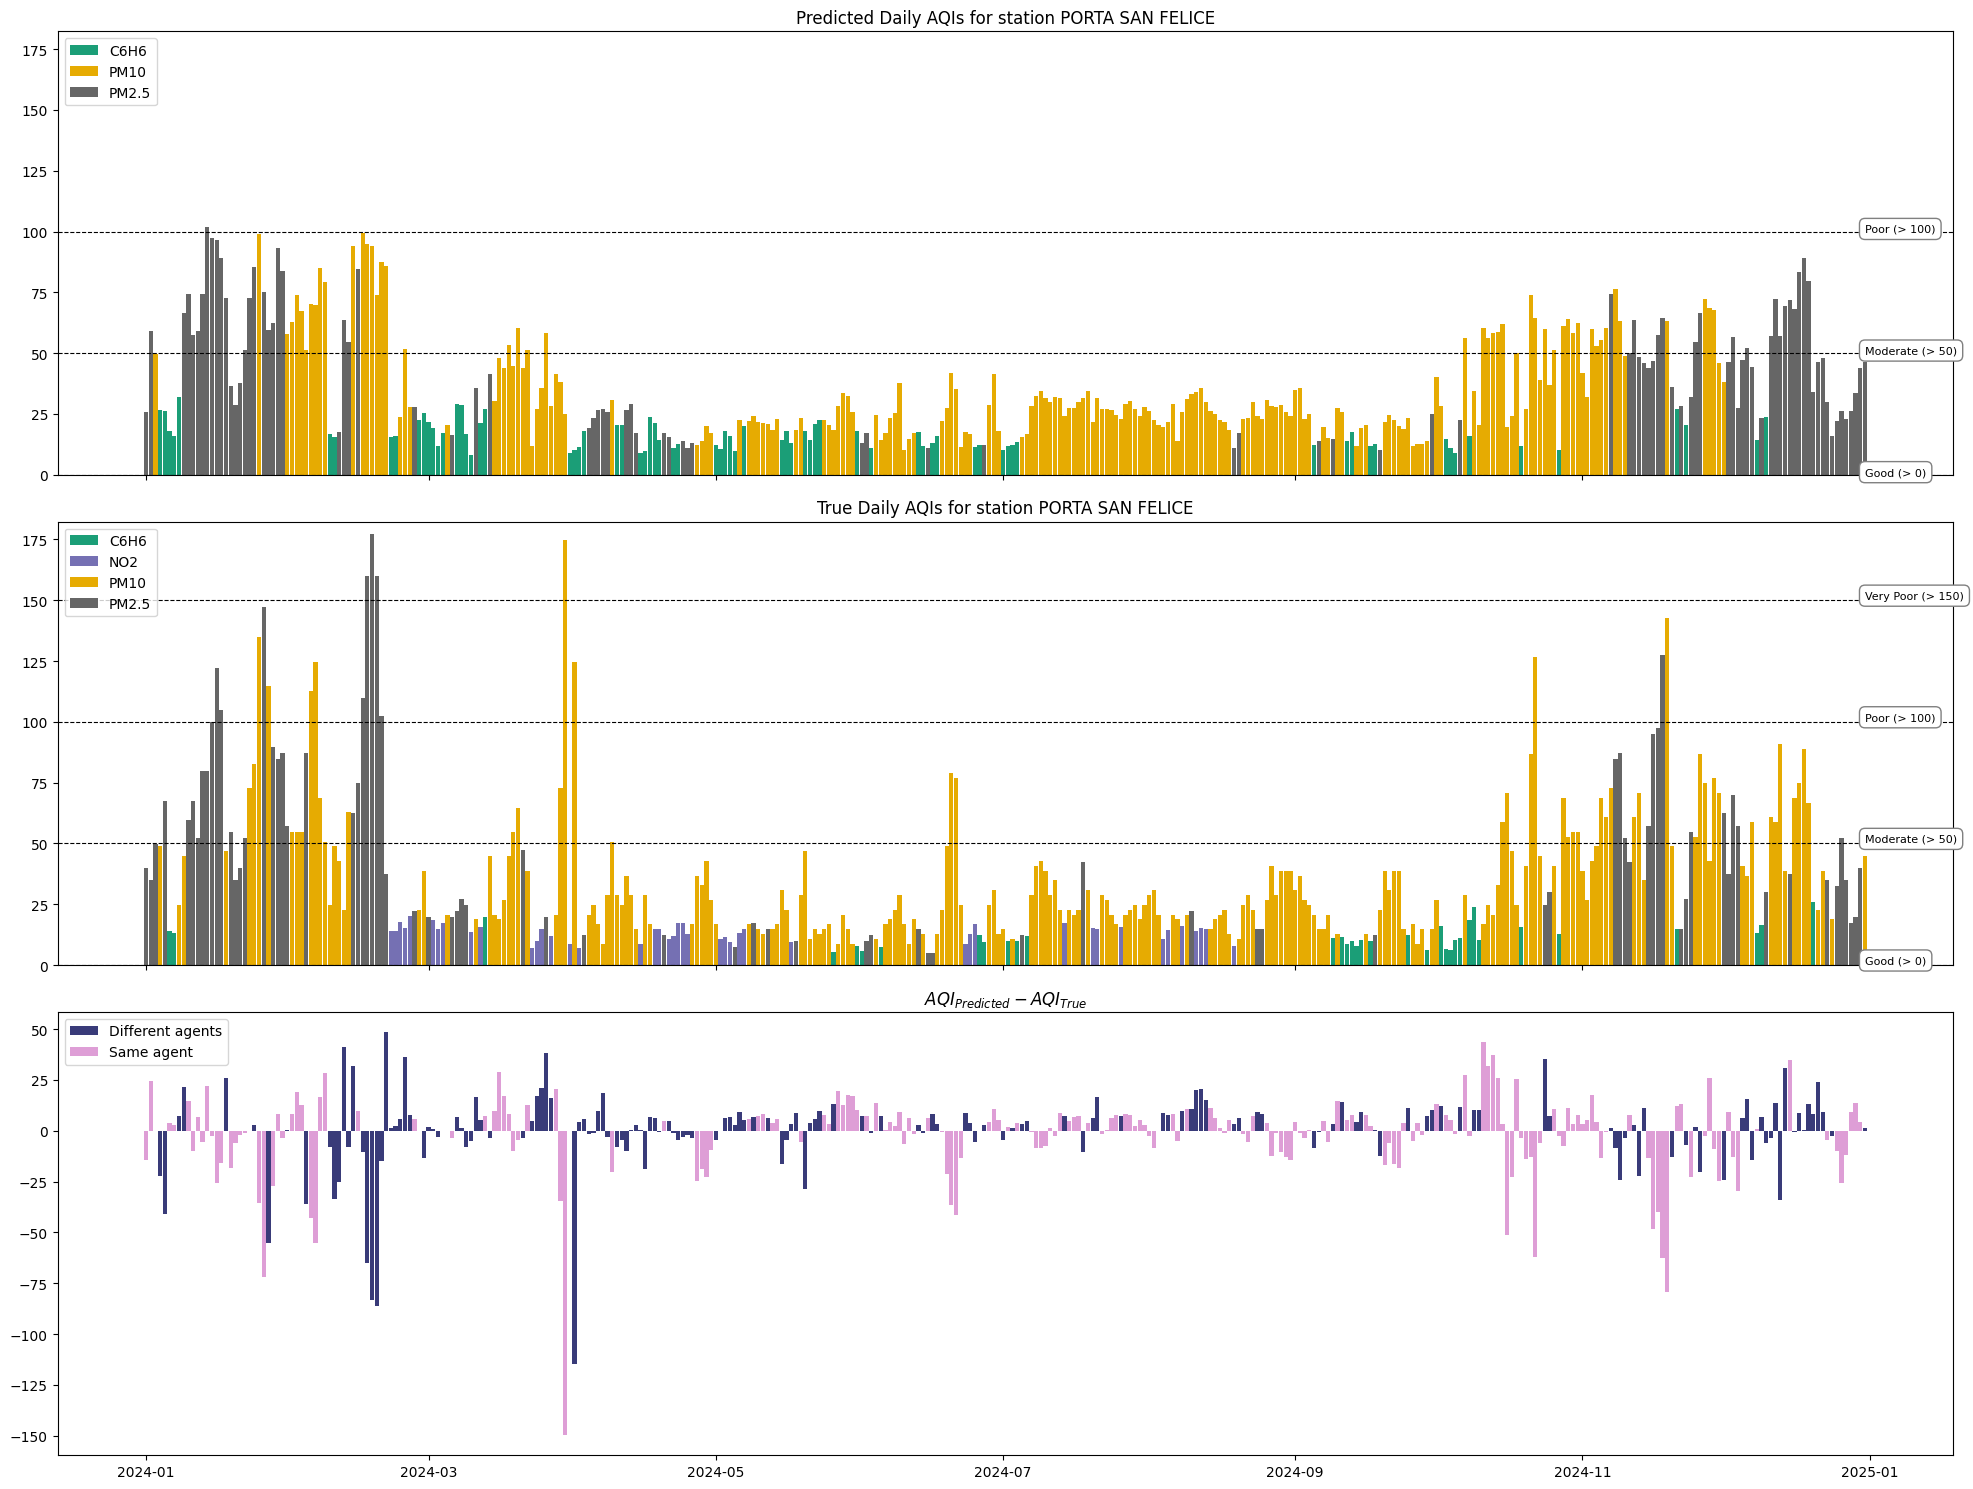

Station VIA CHIARINI AQI:


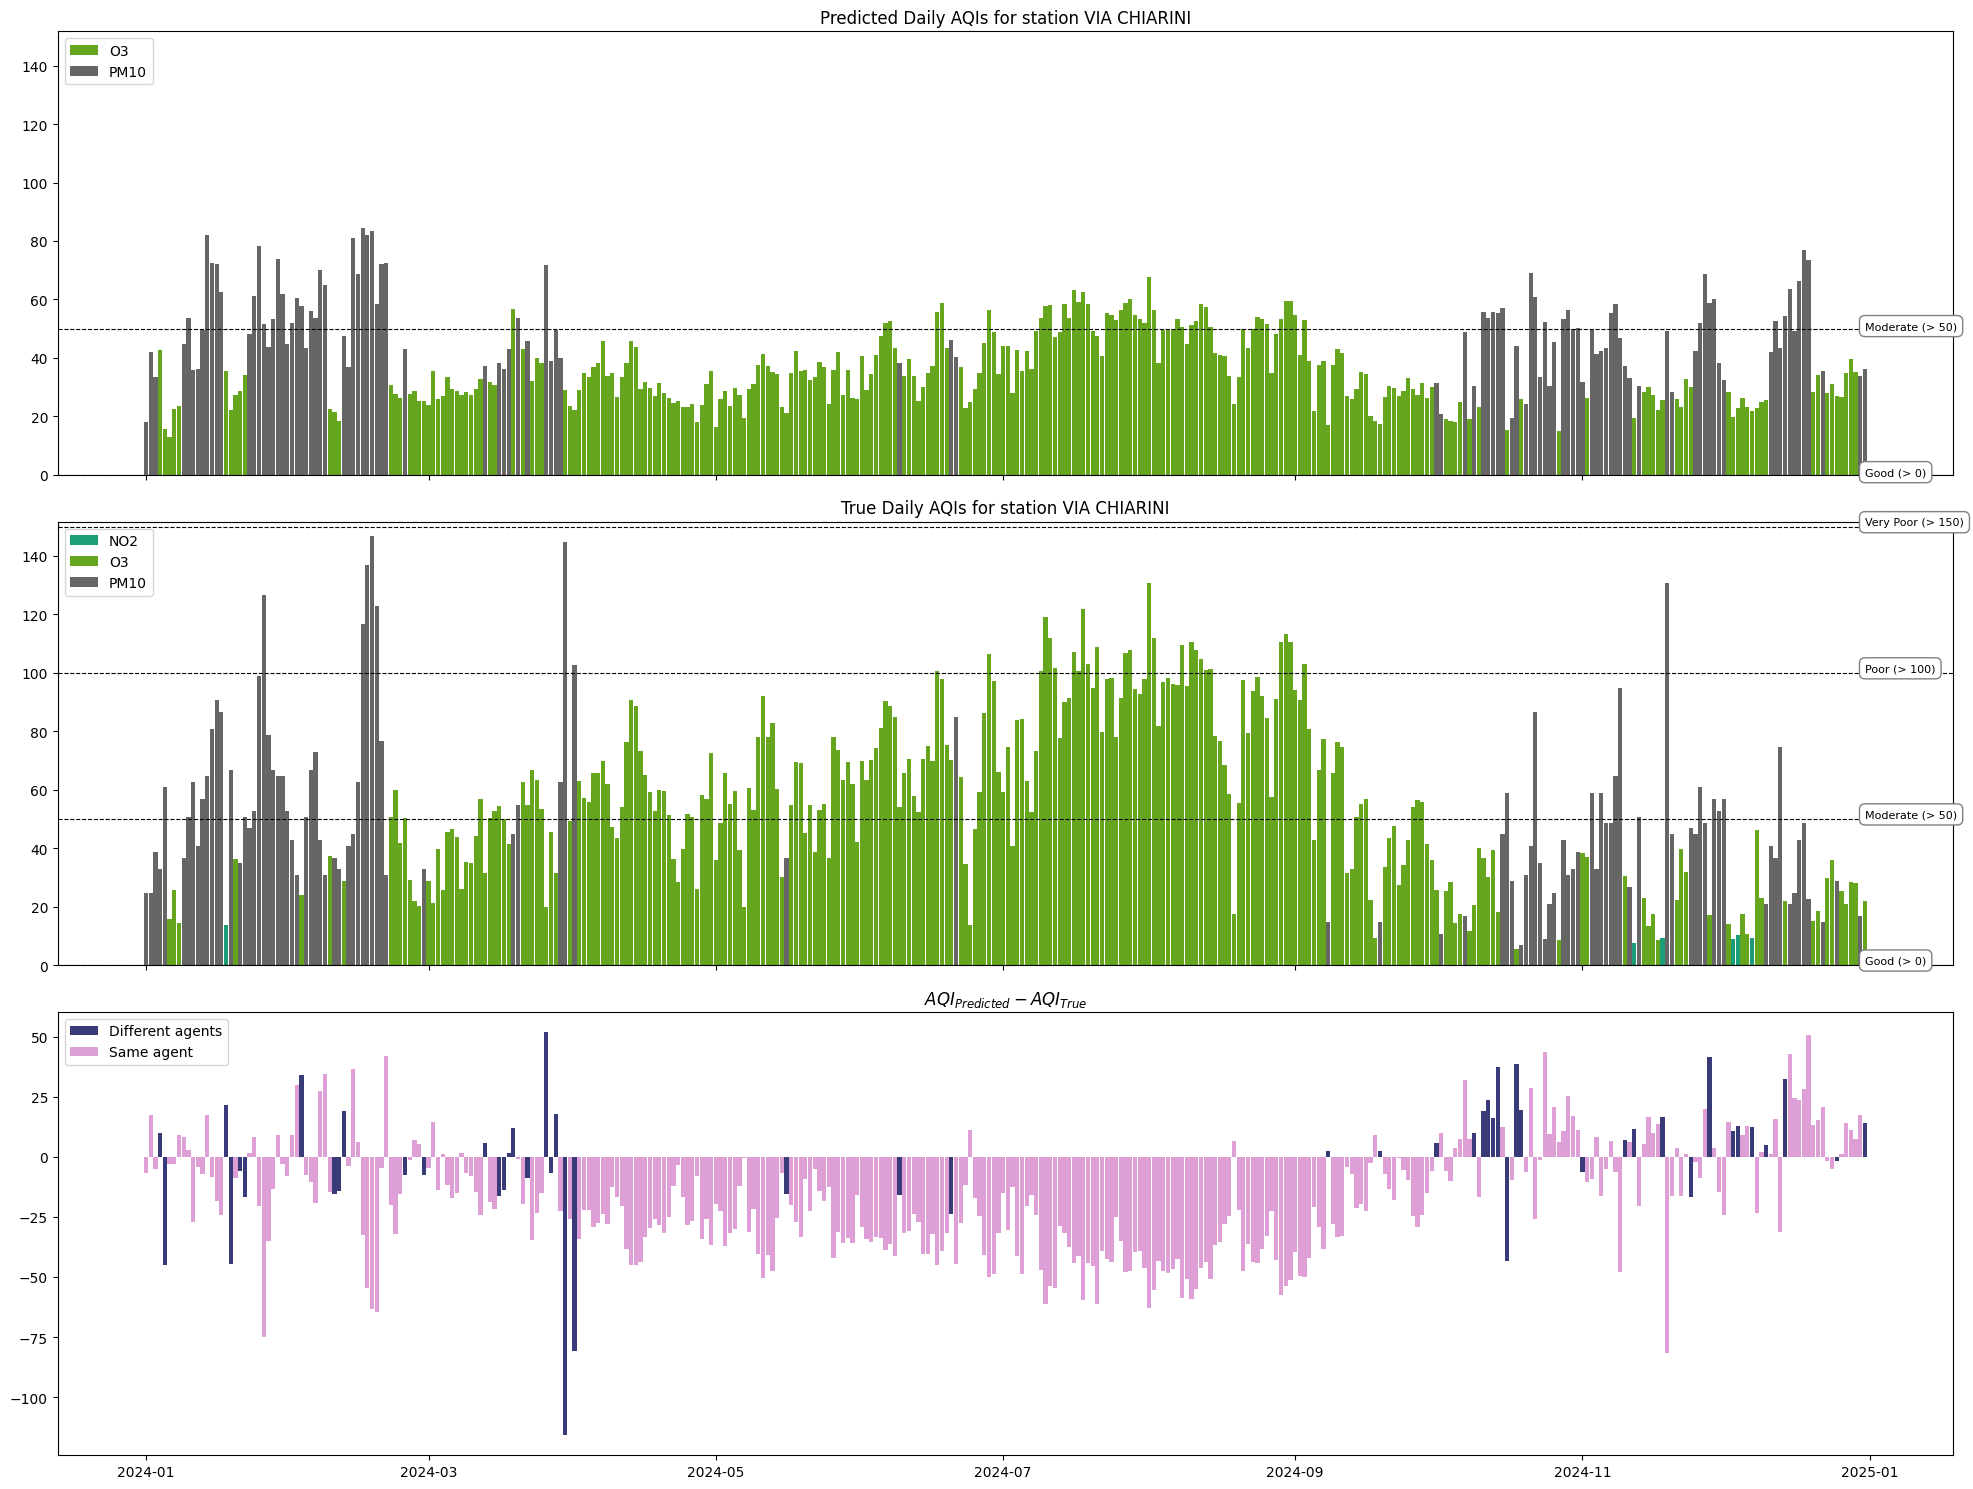

In [116]:
start=datetime(2024,1,1)
end=datetime(2024,12,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        categories=AQI_CATEGORIES,
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA Daily


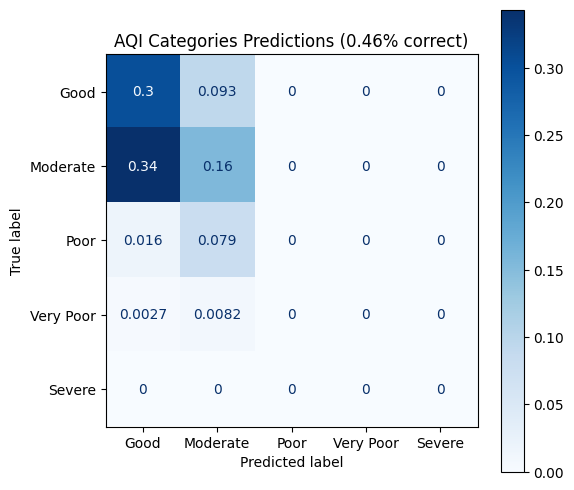

---------------------------------------------
> Absolute Mean AQI Difference: 26.54
> Positive Average AQI Difference: 16.92
> Negative Average AQI Difference: -29.53
> Percentage of Positive Differences: 23.71%
> Percentage of Negative Differences: 76.29%
> Percentage of Agent Values:
   - Same agent: 77.66
   - Different agents: 22.34
Station PORTA SAN FELICE Daily


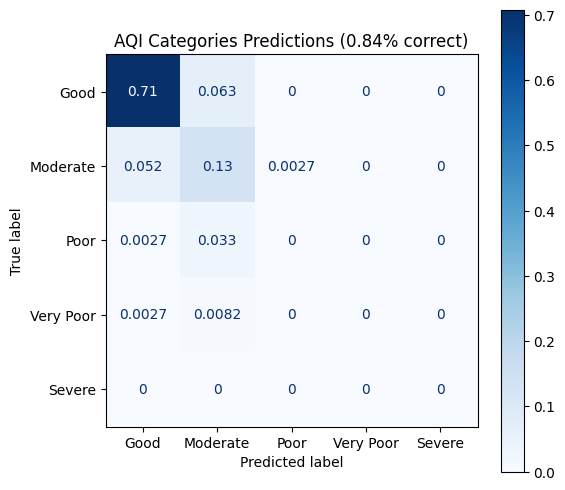

---------------------------------------------
> Absolute Mean AQI Difference: 12.79
> Positive Average AQI Difference: 9.93
> Negative Average AQI Difference: -16.69
> Percentage of Positive Differences: 57.77%
> Percentage of Negative Differences: 42.23%
> Percentage of Agent Values:
   - Same agent: 54.22
   - Different agents: 45.78
Station VIA CHIARINI Daily


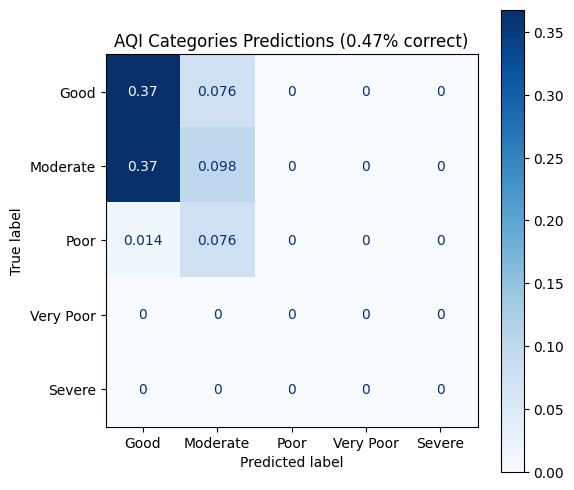

---------------------------------------------
> Absolute Mean AQI Difference: 24.63
> Positive Average AQI Difference: 15.39
> Negative Average AQI Difference: -27.95
> Percentage of Positive Differences: 26.43%
> Percentage of Negative Differences: 73.57%
> Percentage of Agent Values:
   - Same agent: 86.38
   - Different agents: 13.62


In [117]:
for station in pred_AQI_daily:
    print('=============================================')
    print(f'Station {station} Daily')
    print('=============================================')
    print_AQI_category_comparison(
        pred_AQI_daily[station], true_AQI_daily[station], 
        categories=AQI_CATEGORIES
    )
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_daily[station])
    print('=============================================')

## **More detailed AQI display**

In [118]:
max = 200
step = 10

dense_categories = {
    str(i): i * step for i in range(0, max//step + 1)
}

### **Hourly**

Station GIARDINI MARGHERITA Hourly


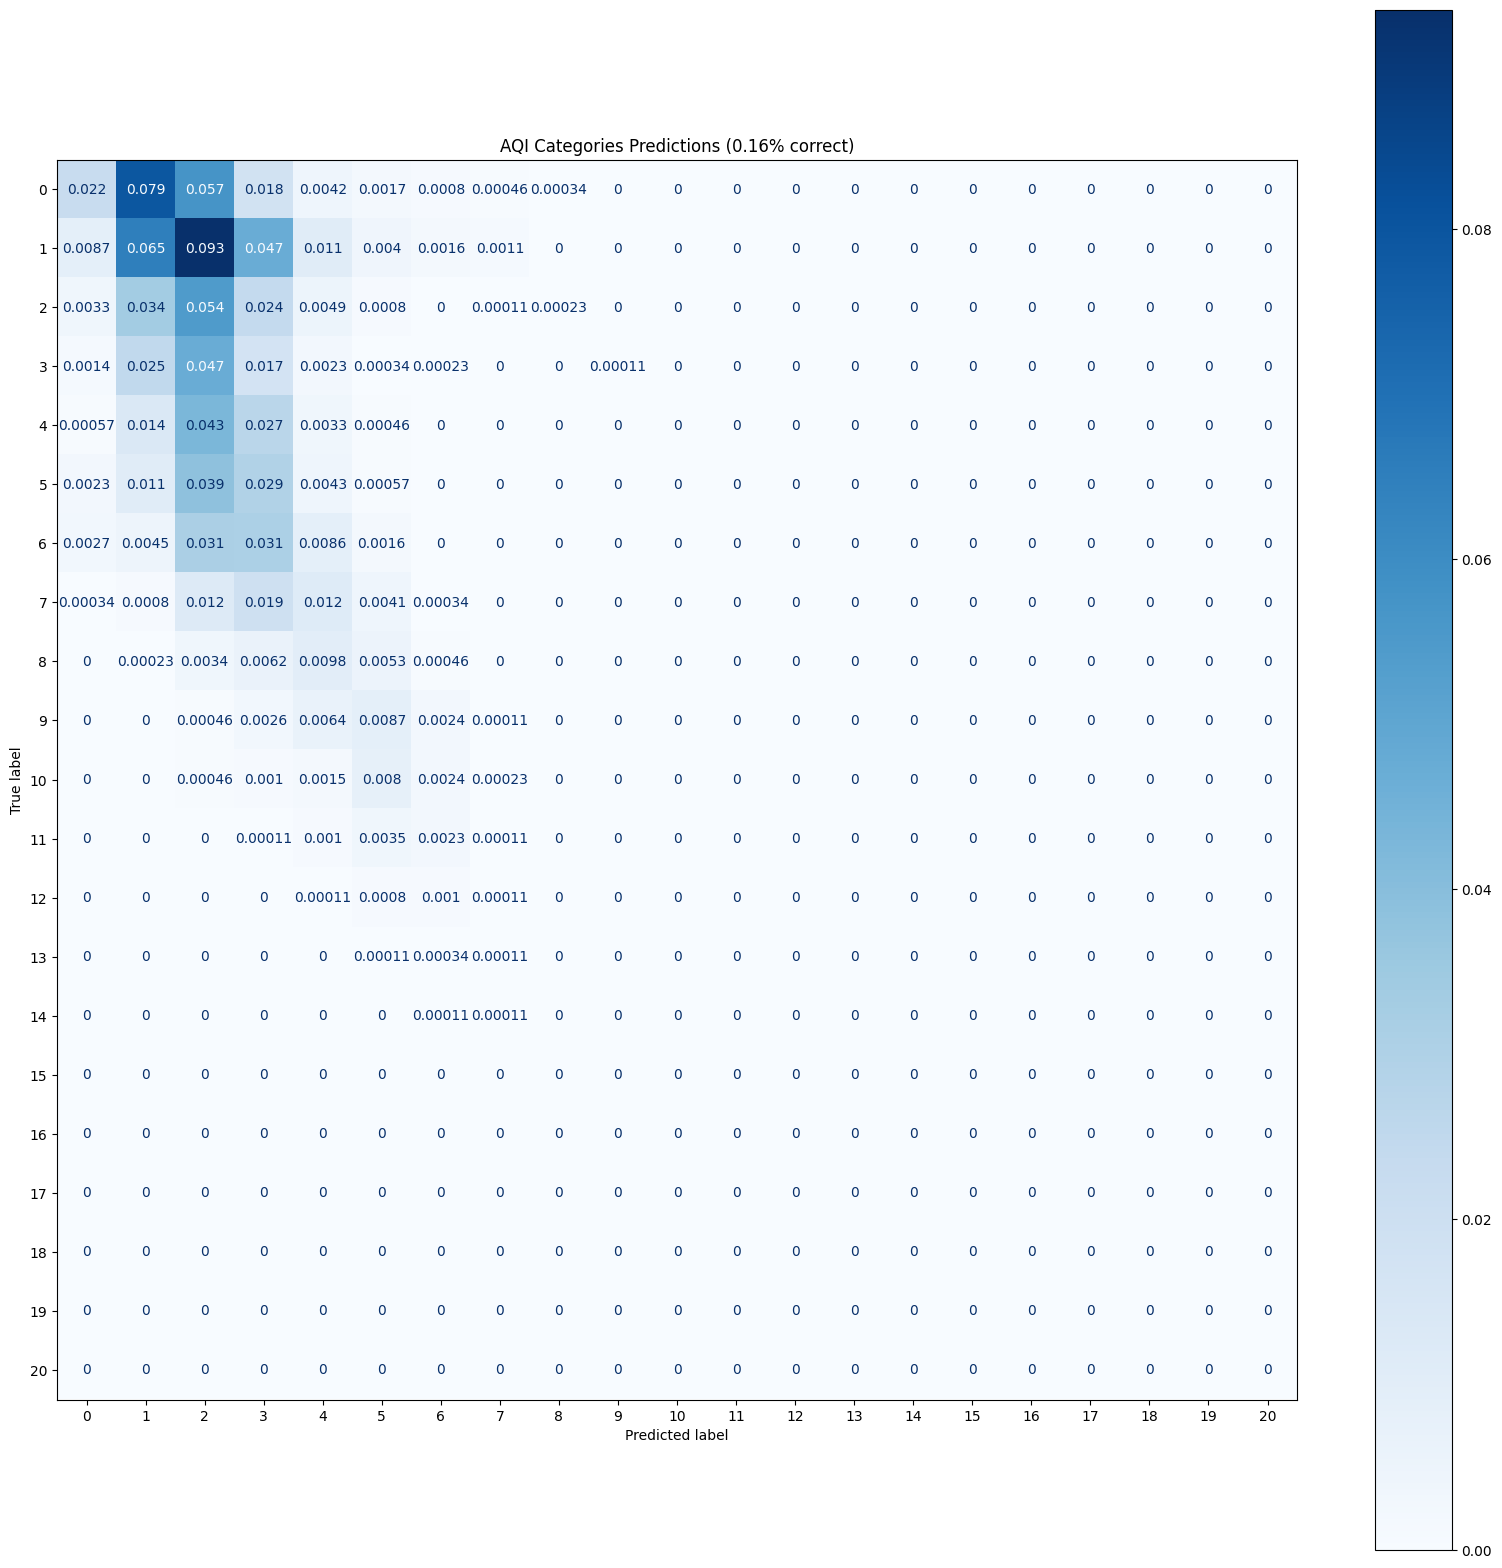

Station PORTA SAN FELICE Hourly


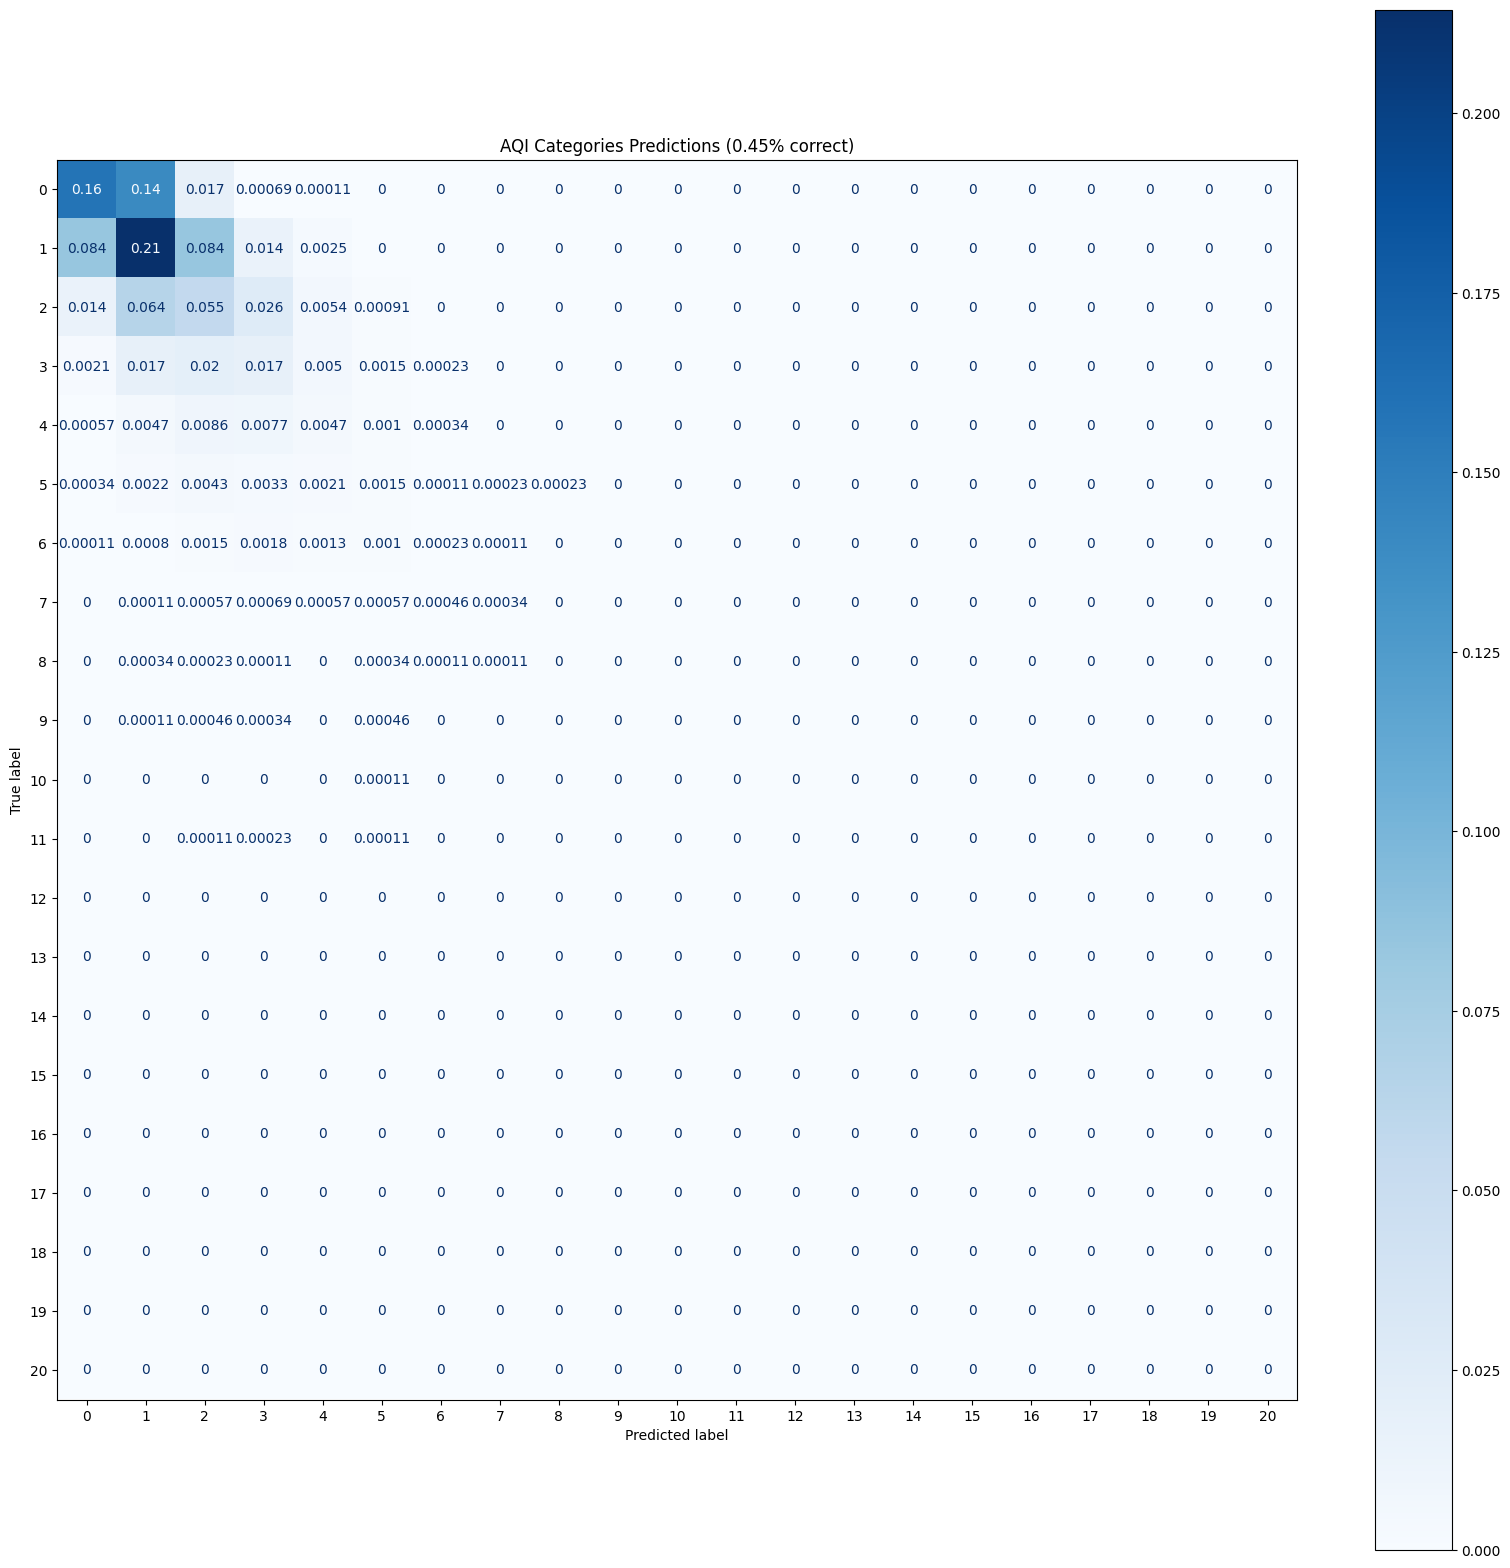

Station VIA CHIARINI Hourly


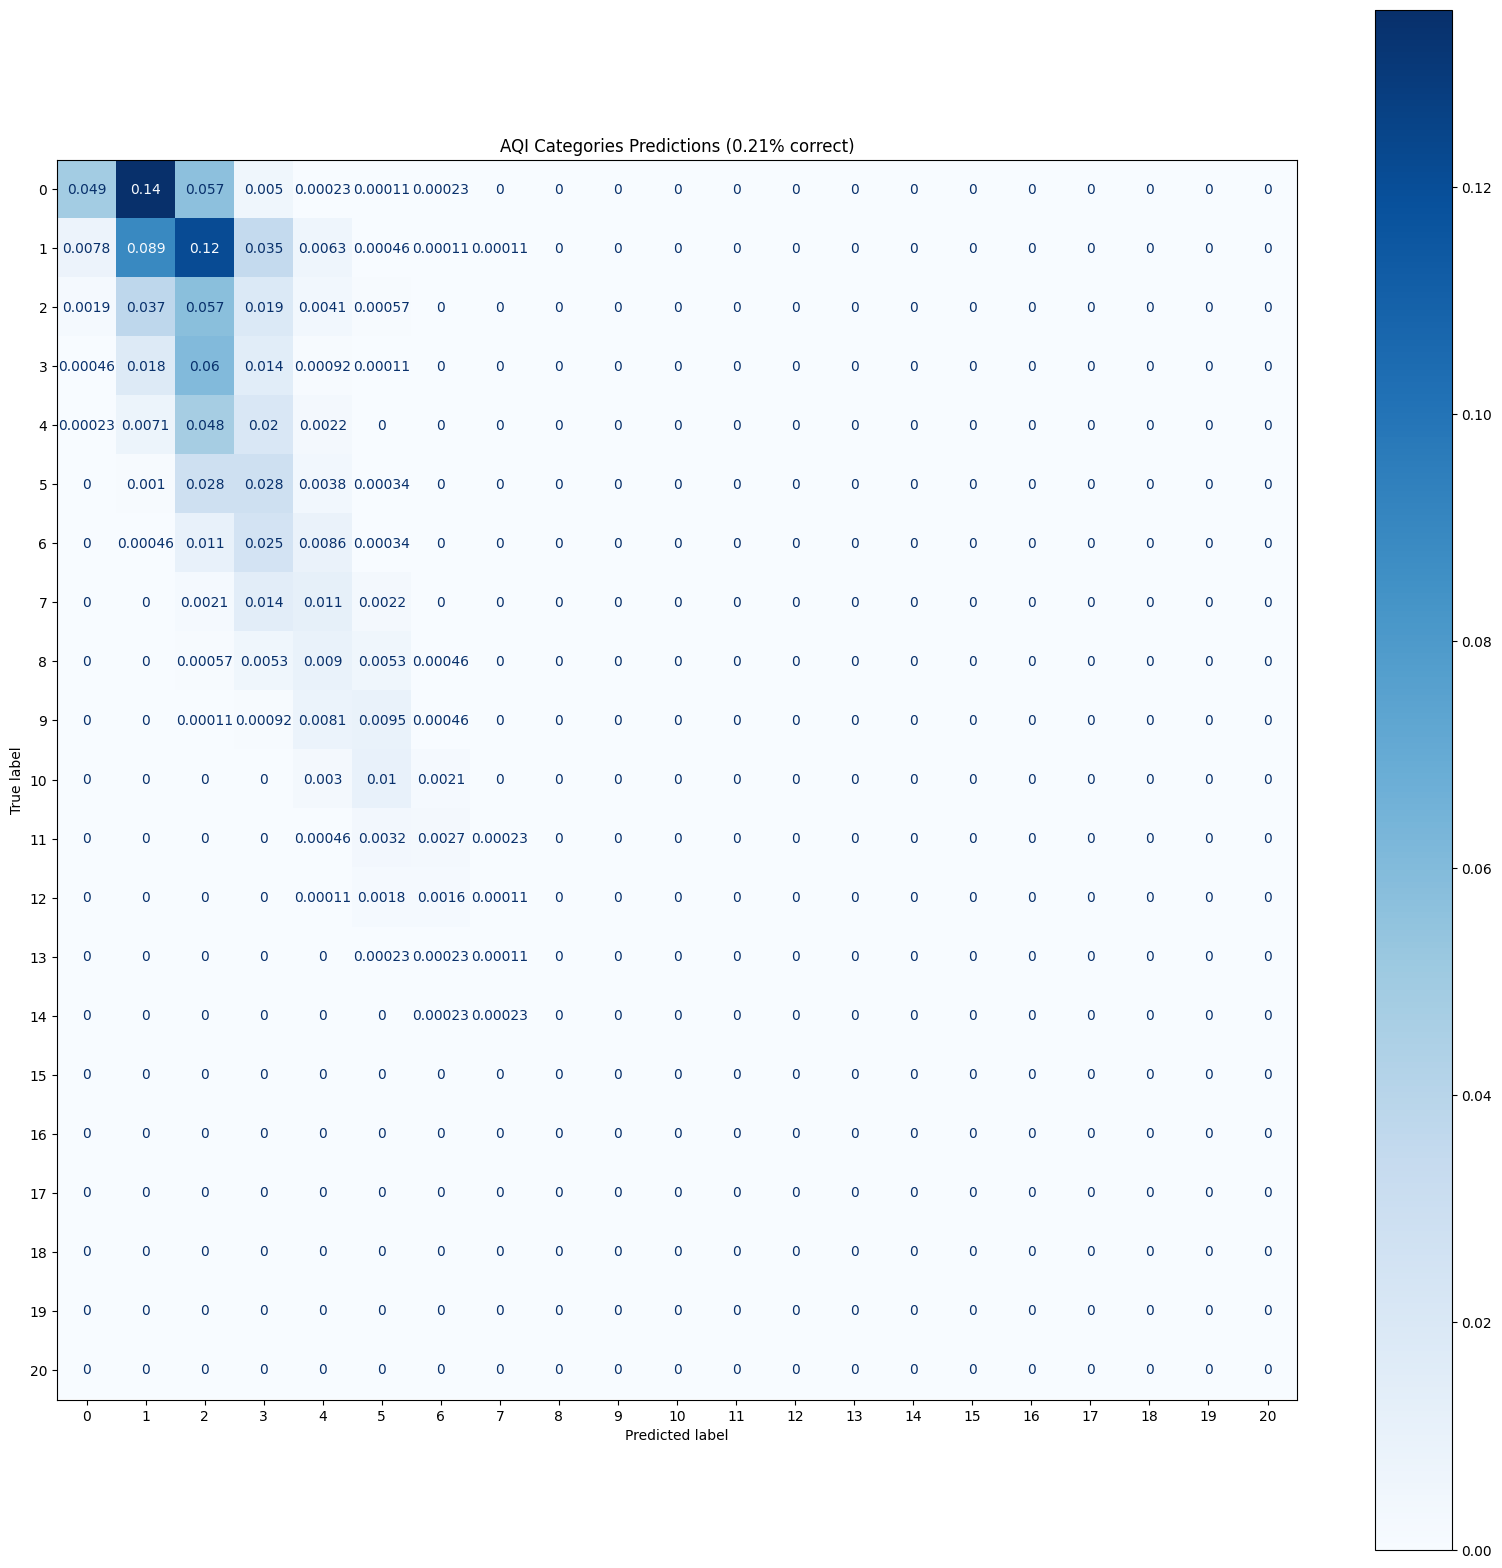

In [119]:
for station in pred_AQI_hourly:
    print(f'Station {station} Hourly')
    print_AQI_category_comparison(
        pred_AQI_hourly[station], true_AQI_hourly[station], 
        categories=dense_categories,
        figsize=(20,20)
    )

### **Daily**

Station GIARDINI MARGHERITA Daily


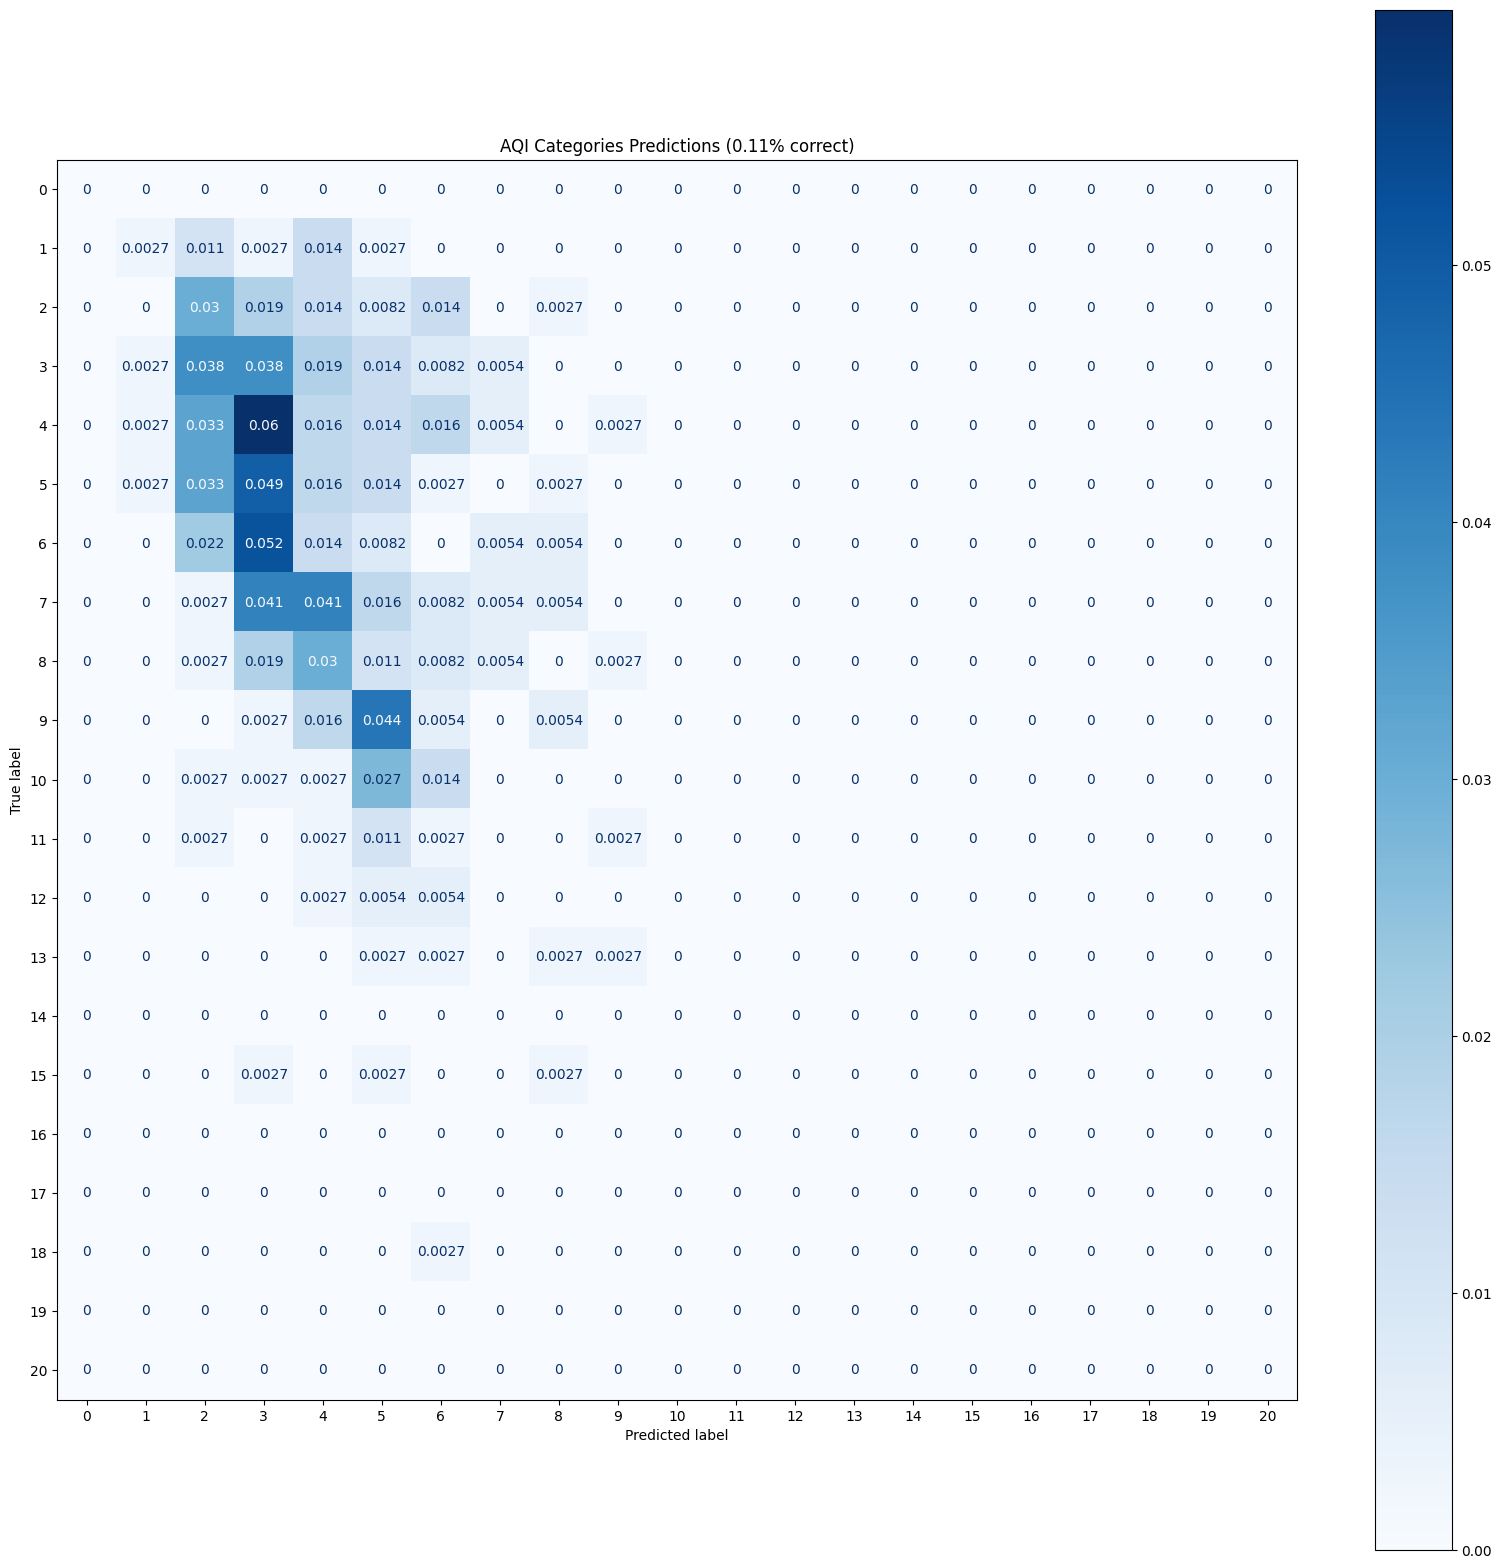

Station PORTA SAN FELICE Daily


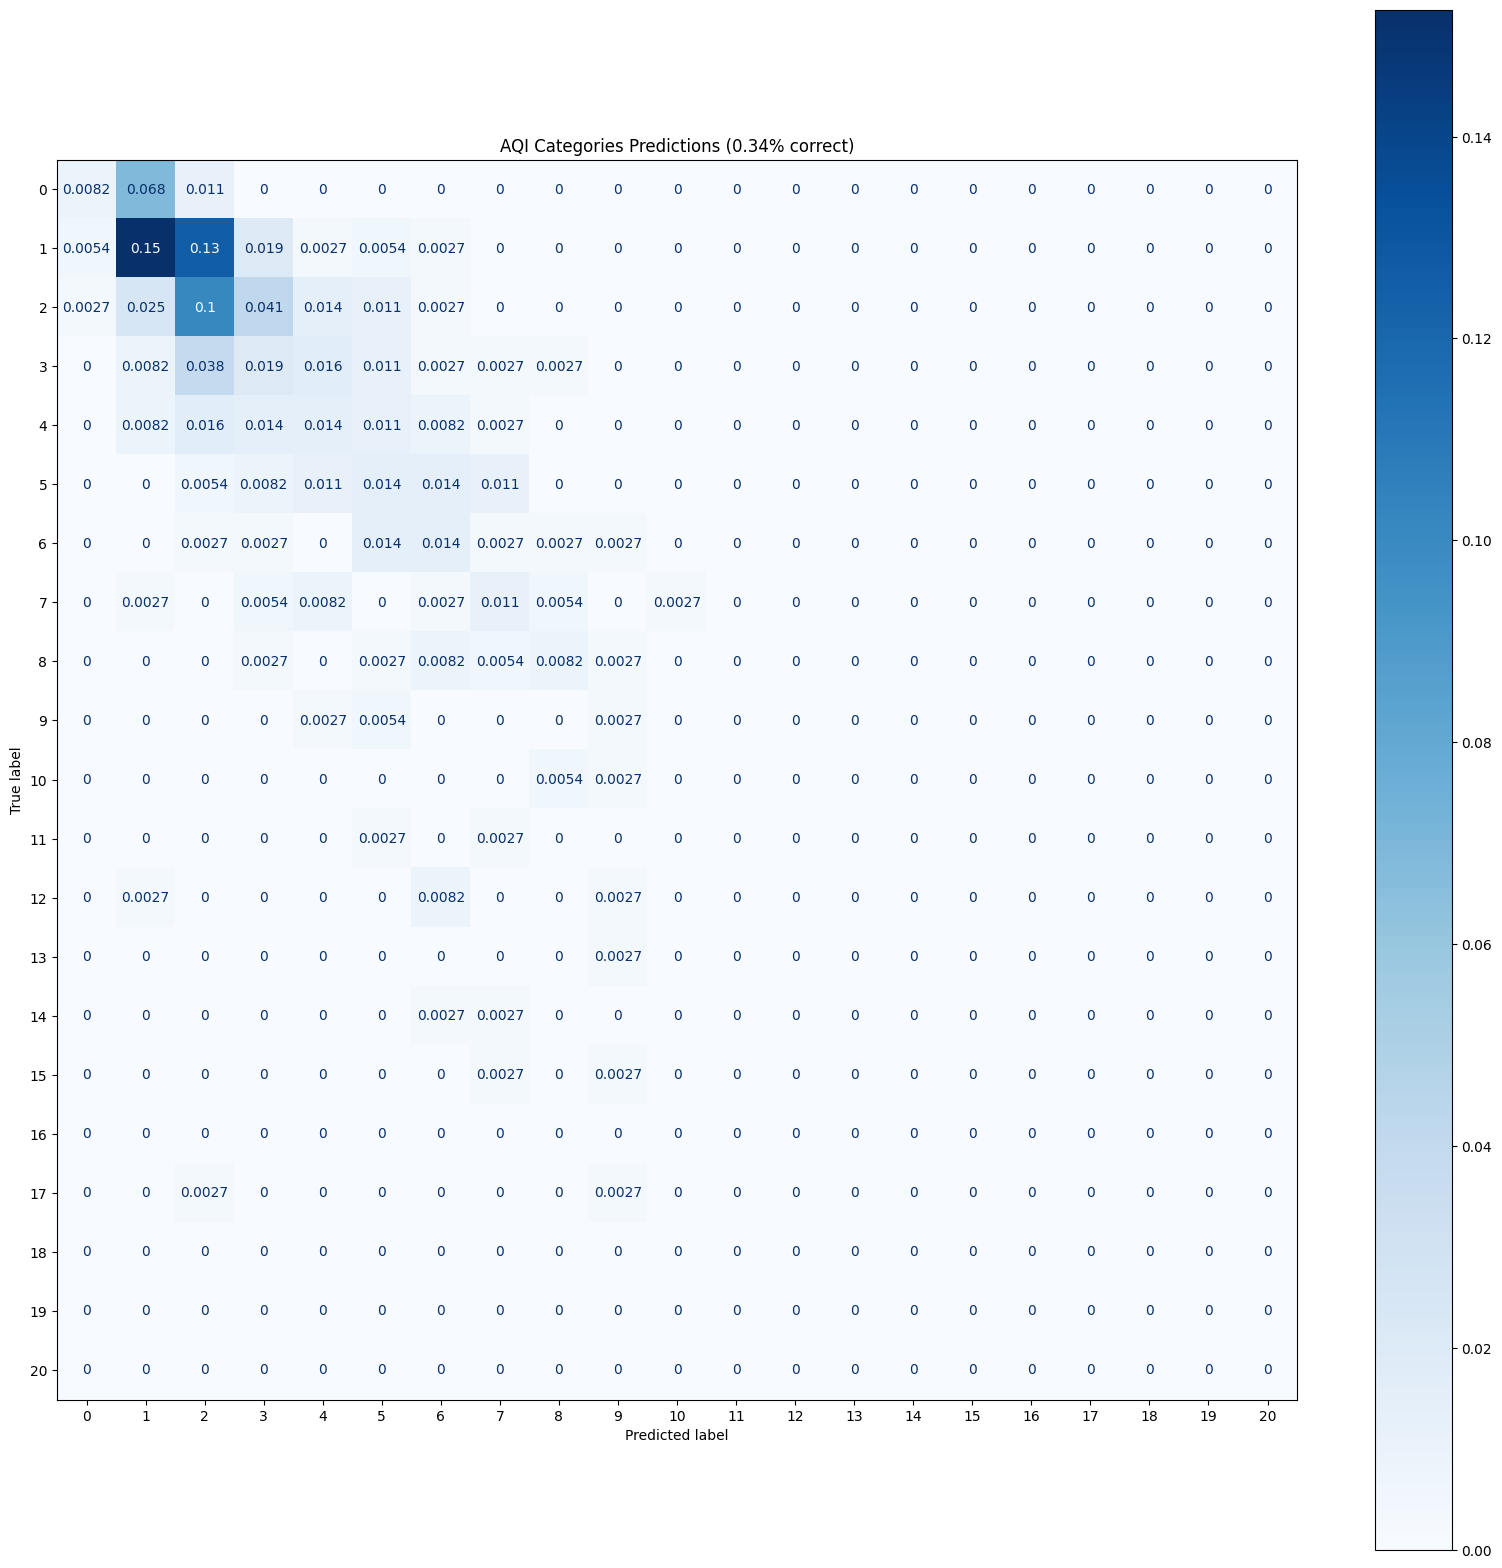

Station VIA CHIARINI Daily


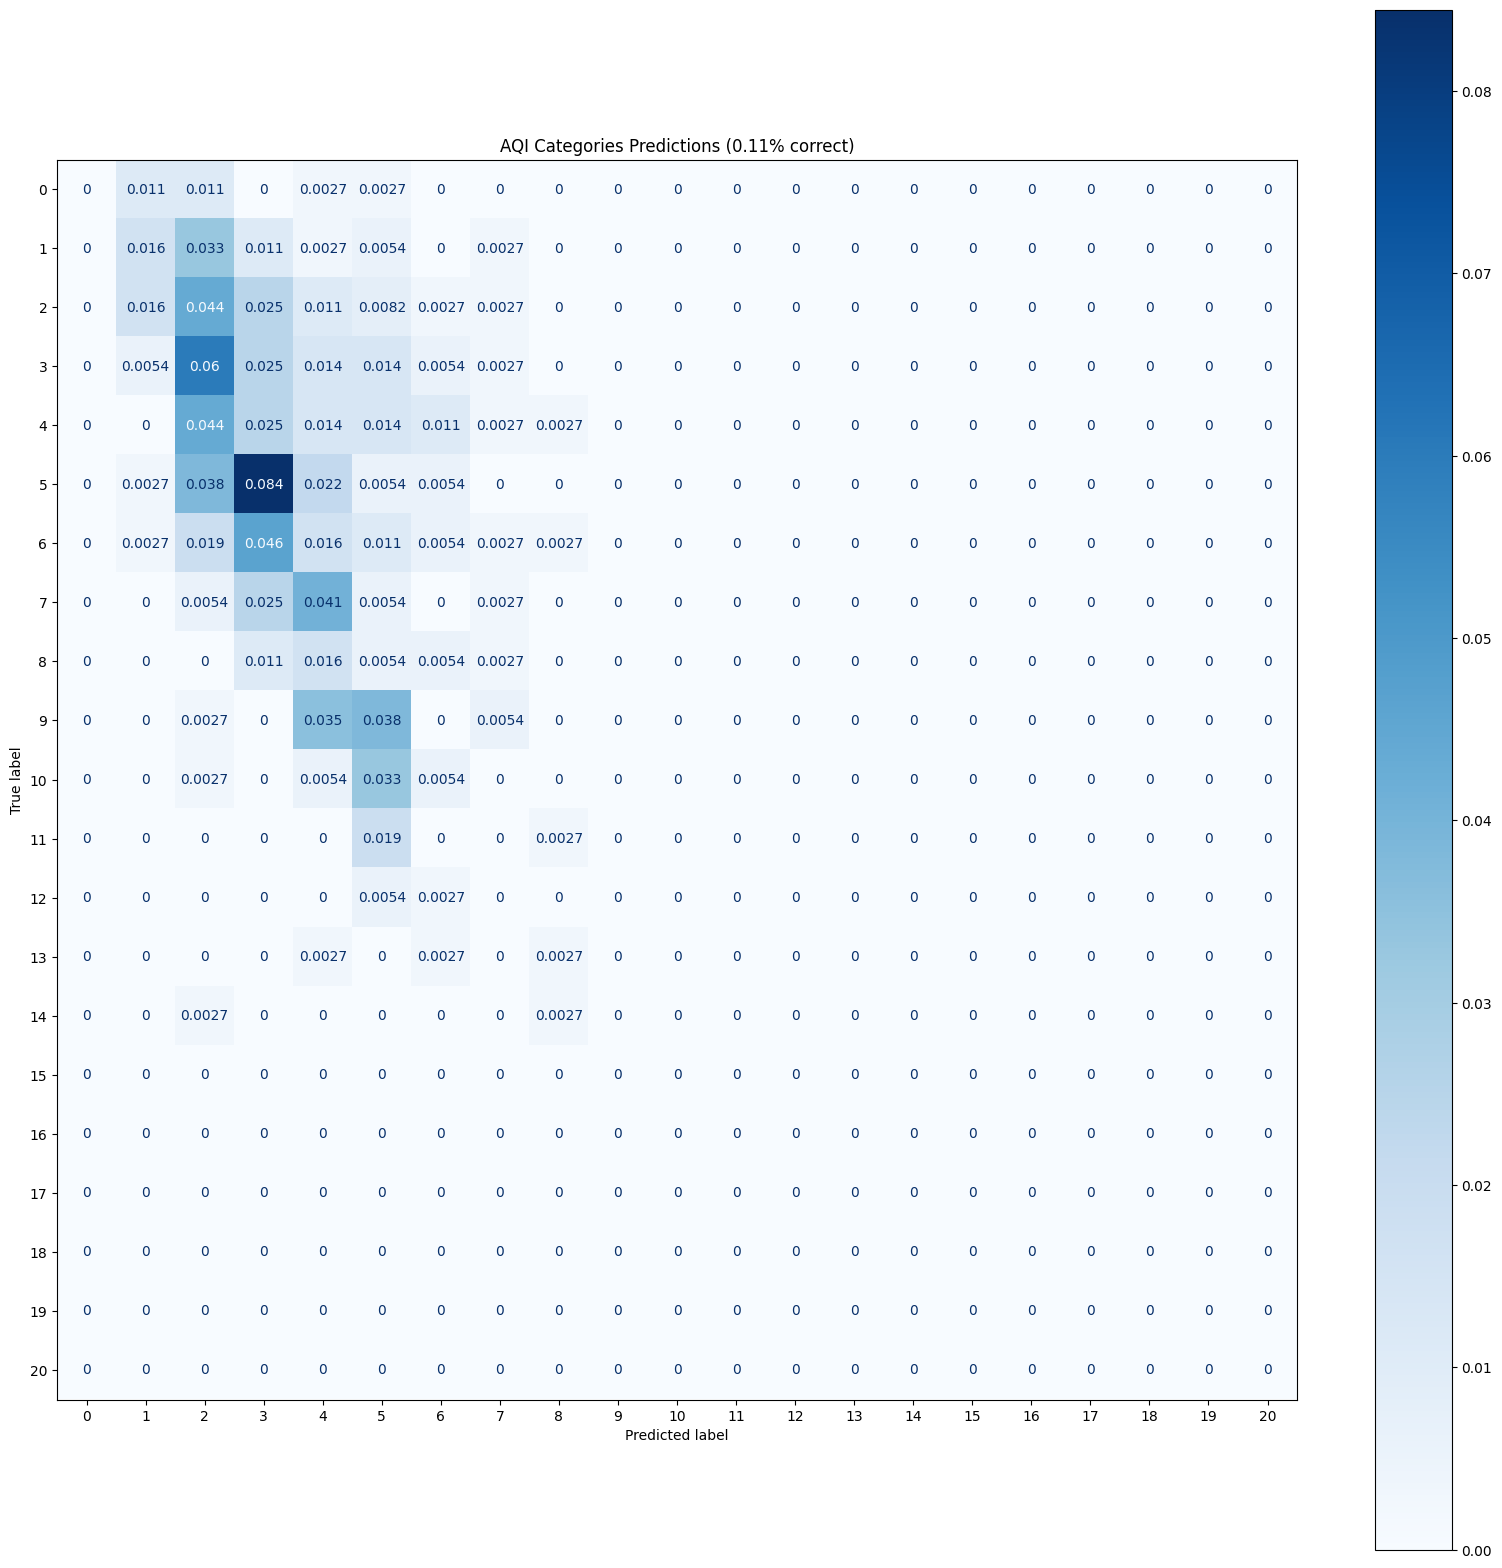

In [120]:
for station in pred_AQI_daily:
    print(f'Station {station} Daily')
    print_AQI_category_comparison(
        pred_AQI_daily[station], true_AQI_daily[station], 
        categories=dense_categories,
        figsize=(20,20)
    )